## Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import os
from openpyxl import Workbook, load_workbook
from openpyxl.styles import Font

import torch
import torch.nn as nn
from torch.nn import Parameter
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from sklearn.model_selection import train_test_split
from sklearn.metrics import cohen_kappa_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.utils.class_weight import compute_class_weight

from utils.layer_wrappers import ModuleWrapperLinear, ModuleWrapperConv1d
from layers.BayesianConv1d import BayesianConv1d
from layers.BayesianLinear import BayesianLinear

## Parameters

In [2]:
BATCH_SIZE = 64
NUM_CLASSES = 3
LR = 1e-3
KL_WEIGHT = 1e-8
EPOCHS = 15
T = 15

PRIORS = {
    'prior_mu': 0,
    'prior_sigma': 0.1,
    'posterior_mu_initial': (0.0, 0.1),
    'posterior_rho_initial': (-3.0, 0.1)
}  

SITE = 'B'
YEAR = 2020

flag_subsampled = True

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using Device: {DEVICE}')

Using Device: cuda


## Loading Files

In [3]:
X = np.load(f'/kaggle/input/data-usa/Site_{SITE}/x-{YEAR}.npy')
y = np.load(f'/kaggle/input/data-usa/Site_{SITE}/y-{YEAR}.npy')

print(f'Loaded Data of Site {SITE} - {YEAR}')
print(X.shape, y.shape)

Loaded Data of Site B - 2020
(1943716, 28, 6) (1943716,)


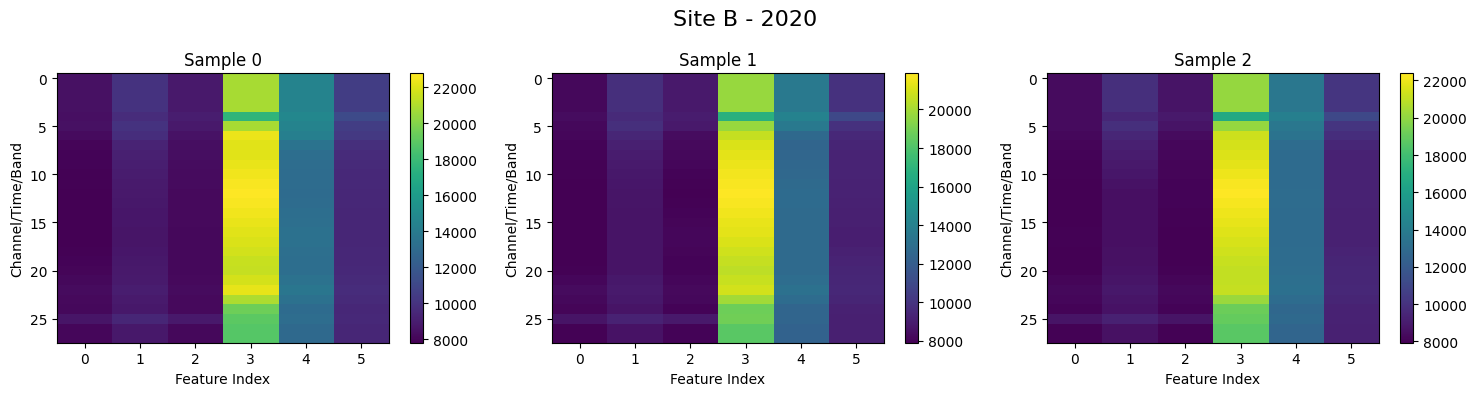

In [4]:
# Ploting the preprocessed feature maps
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

for i in range(3):
    im = axes[i].imshow(X[i], aspect='auto', cmap='viridis')
    axes[i].set_title(f"Sample {i}")
    axes[i].set_xlabel("Feature Index")
    axes[i].set_ylabel("Channel/Time/Band")
    fig.colorbar(im, ax=axes[i], orientation='vertical')

fig.suptitle(f"Site {SITE} - {YEAR}", fontsize=16)
plt.tight_layout()
plt.show()

In [5]:
print(f'\n\n======= For Site {SITE} - {YEAR} =======')
feature_means = X.mean(axis=(0, 1))  # average over samples and features
feature_stds = X.std(axis=(0, 1))

for i, (m, s) in enumerate(zip(feature_means, feature_stds)):
    print(f"Feature {i}: Mean = {m:.4f}, Std = {s:.4f}")

# Compute overall mean and std
mean = X.mean()
std = X.std()

print(f"\nGlobal Mean: {mean:.4f}")
print(f"Global Std Dev: {std:.4f}")



======= For Site B - 2020 =======
Feature 0: Mean = 9293.7332, Std = 1062.0828
Feature 1: Mean = 10402.3986, Std = 1328.2403
Feature 2: Mean = 10579.1004, Std = 1999.1082
Feature 3: Mean = 18968.7555, Std = 4274.7314
Feature 4: Mean = 16319.4431, Std = 3346.2848
Feature 5: Mean = 13205.7260, Std = 3494.6972

Global Mean: 13128.1928
Global Std Dev: 4500.1056


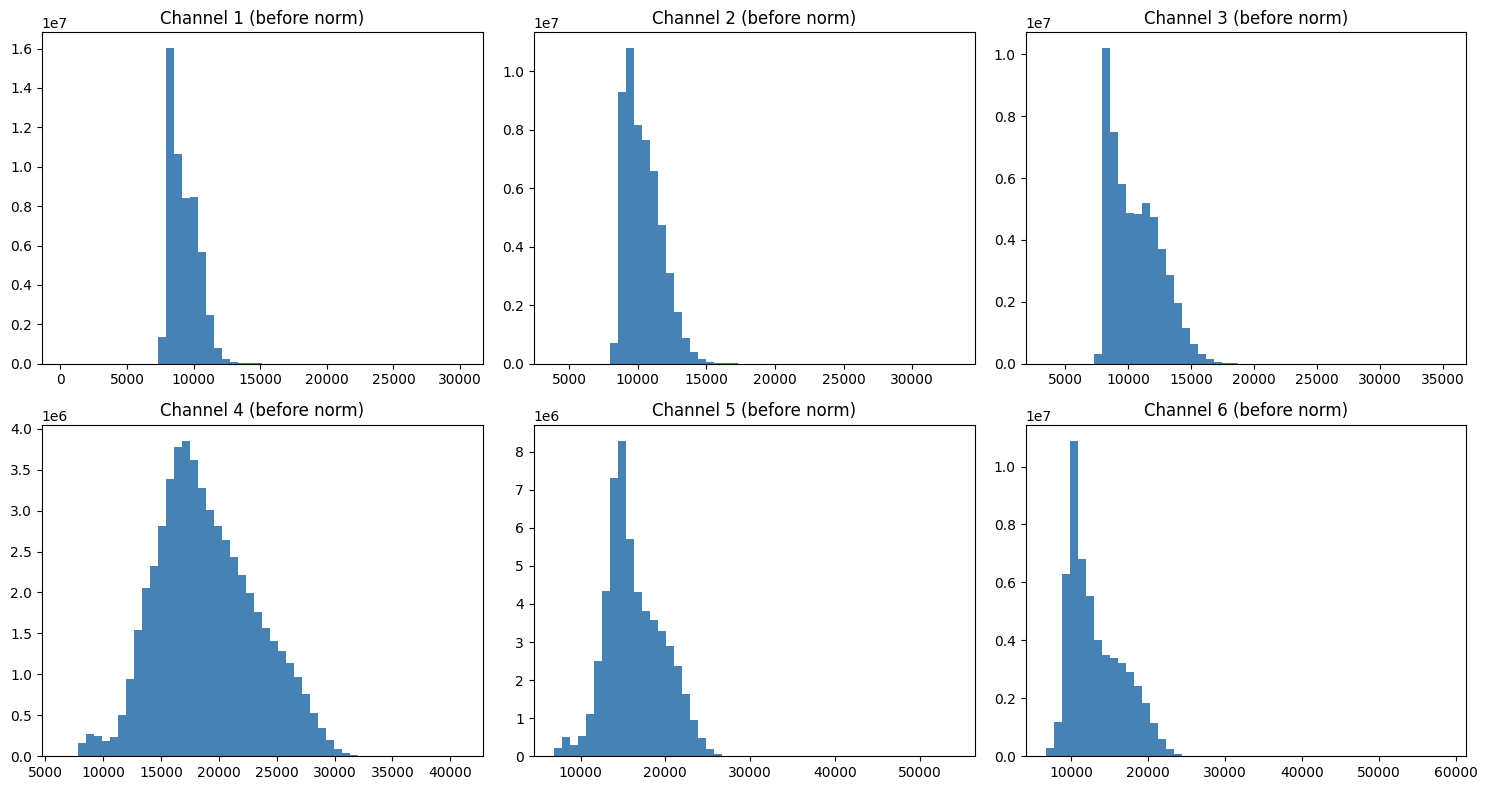

In [6]:
X_hist = X.reshape(-1, 6)  # shape: (N*T, 6)

# Before normalization
fig, axs = plt.subplots(2, 3, figsize=(15, 8))
axs = axs.ravel()

for i in range(6):
    axs[i].hist(X_hist[:, i], bins=50, color='steelblue', alpha=1)
    axs[i].set_title(f'Channel {i+1} (before norm)')
plt.tight_layout()
plt.show()

## Preprocessing the Input

In [7]:
# Standardizing the input features across all timesteps and samples using Z-scores
# Compute per-feature mean and std across all samples and timesteps
feature_means = X.mean(axis=(0, 1))  # Shape: (6,)
feature_stds = X.std(axis=(0, 1))    # Shape: (6,)

# Reshape for broadcasting
feature_means = feature_means.reshape(1, 1, -1)  # Shape: (1, 1, 6)
feature_stds = feature_stds.reshape(1, 1, -1)    # Shape: (1, 1, 6)

# Standardize
X = ((X - feature_means) / feature_stds).astype(np.float32)

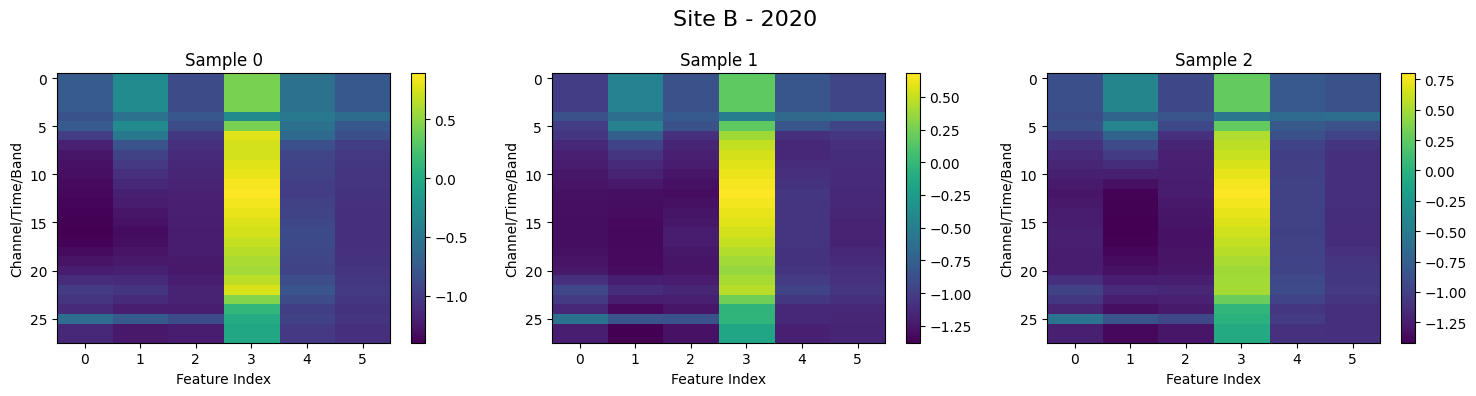

In [8]:
# Ploting the preprocessed feature maps
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

for i in range(3):
    im = axes[i].imshow(X[i], aspect='auto', cmap='viridis')
    axes[i].set_title(f"Sample {i}")
    axes[i].set_xlabel("Feature Index")
    axes[i].set_ylabel("Channel/Time/Band")
    fig.colorbar(im, ax=axes[i], orientation='vertical')

fig.suptitle(f"Site {SITE} - {YEAR}", fontsize=16)
plt.tight_layout()
plt.show()

In [9]:
print(f'\n\n======= For Site {SITE} - {YEAR} =======')
feature_means = X.mean(axis=(0, 1))  # average over samples and features
feature_stds = X.std(axis=(0, 1))

for i, (m, s) in enumerate(zip(feature_means, feature_stds)):
    print(f"Feature {i}: Mean = {m:.4f}, Std = {s:.4f}")

# Compute overall mean and std
mean = X.mean()
std = X.std()

print(f"\nGlobal Mean: {mean:.4f}")
print(f"Global Std Dev: {std:.4f}")



======= For Site B - 2020 =======
Feature 0: Mean = -0.0000, Std = 0.8846
Feature 1: Mean = -0.0000, Std = 0.8950
Feature 2: Mean = 0.0000, Std = 0.8862
Feature 3: Mean = 0.0001, Std = 0.9253
Feature 4: Mean = 0.0000, Std = 0.9230
Feature 5: Mean = 0.0000, Std = 0.8994

Global Mean: -0.0000
Global Std Dev: 1.0000


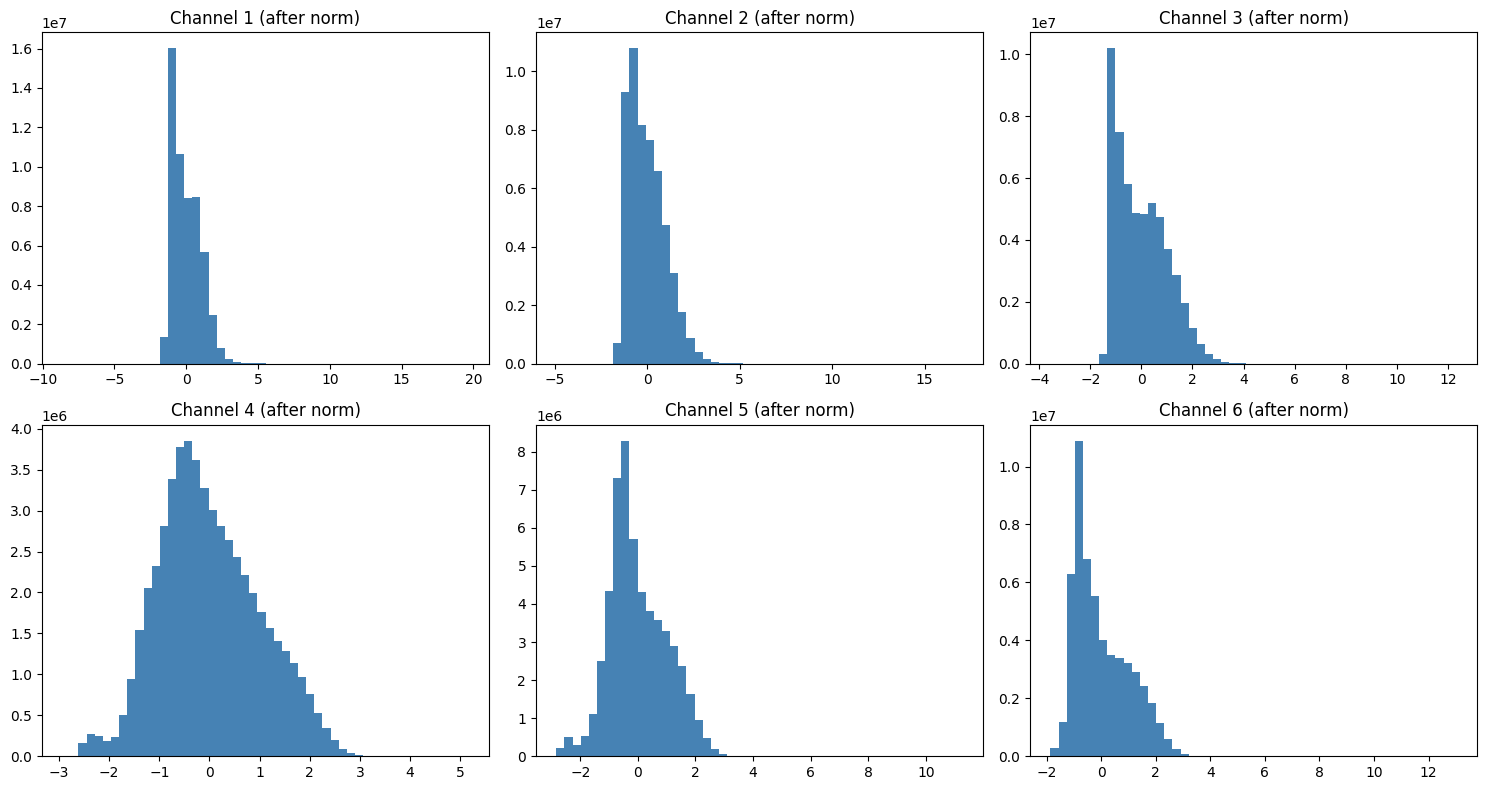

In [10]:
X_hist = X.reshape(-1, 6)  # shape: (N*T, 6)

# After normalization
fig, axs = plt.subplots(2, 3, figsize=(15, 8))
axs = axs.ravel()

for i in range(6):
    axs[i].hist(X_hist[:, i], bins=50, color='steelblue', alpha=1)
    axs[i].set_title(f'Channel {i+1} (after norm)')
plt.tight_layout()
plt.show()

## Label Distribution



====== Label Distribution ======
Label     Count     Percentage
------------------------------
0         871034    44.81%
1         260775    13.42%
2         811907    41.77%

Total samples: 1943716


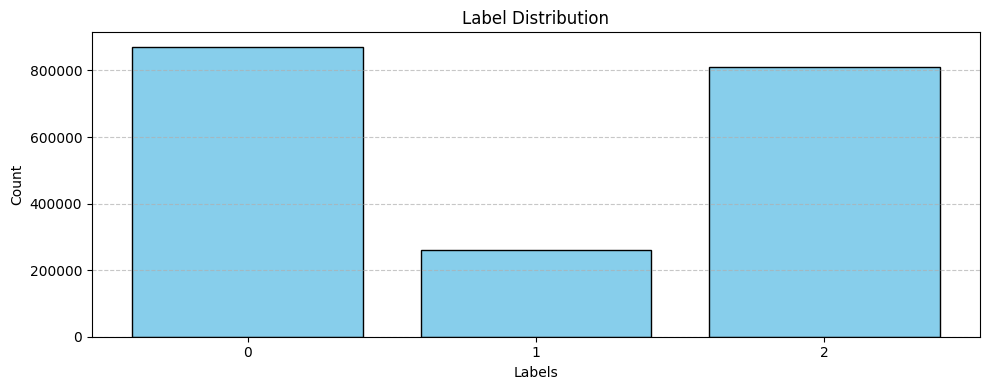

In [11]:
# Checking the label distribution of training data
print('\n\n====== Label Distribution ======')
unique_labels, counts = np.unique(y, return_counts=True)
total = counts.sum()
print(f"{'Label':<10}{'Count':<10}{'Percentage':<10}")
print("-" * 30)
for label, count in zip(unique_labels, counts):
    percentage = (count / total) * 100
    print(f"{label:<10}{count:<10}{percentage:<.2f}%")

print(f"\nTotal samples: {total}")

# Plot histogram for training data
unique_labels, counts = np.unique(y, return_counts=True)
plt.figure(figsize=(10, 4))
plt.bar(unique_labels.astype(str), counts, color='skyblue', edgecolor='black')
plt.xlabel("Labels")
plt.ylabel("Count")
plt.title(f"Label Distribution")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

## Data Splits

In [12]:
# Taking only 25% percent of the data
X_subset, X_test, y_subset, y_test = train_test_split(X, y, test_size=0.75, stratify=y, random_state=42)
print('Subset Data:', X_subset.shape, y_subset.shape)
print('Test Data:', X_test.shape, y_test.shape)

Subset Data: (485929, 28, 6) (485929,)
Test Data: (1457787, 28, 6) (1457787,)


In [13]:
# Train/Val Split
X_train, X_val, y_train, y_val = train_test_split(X_subset, y_subset, test_size=0.2, stratify=y_subset, random_state=42)
print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)

(388743, 28, 6) (388743,)
(97186, 28, 6) (97186,)


In [14]:
# Checking if the training data is normalized correctly
print(f'\n\n======= Training data =======')
feature_means = X_train.mean(axis=(0, 1))  # average over samples and features
feature_stds = X_train.std(axis=(0, 1))

for i, (m, s) in enumerate(zip(feature_means, feature_stds)):
    print(f"Feature {i}: Mean = {m:.4f}, Std = {s:.4f}")

# Compute overall mean and std
mean = X_train.mean()
std = X_train.std()

print(f"\nGlobal Mean: {mean:.4f}")
print(f"Global Std Dev: {std:.4f}")



======= Training data =======
Feature 0: Mean = 0.0013, Std = 0.9957
Feature 1: Mean = 0.0013, Std = 0.9936
Feature 2: Mean = 0.0009, Std = 0.9921
Feature 3: Mean = 0.0006, Std = 0.9914
Feature 4: Mean = 0.0005, Std = 0.9904
Feature 5: Mean = 0.0004, Std = 0.9946

Global Mean: 0.0008
Global Std Dev: 1.0006




====== Label Distribution - Training data ======
Label     Count     Percentage
------------------------------
0         174206    44.81%
1         52155     13.42%
2         162382    41.77%

Total samples: 388743


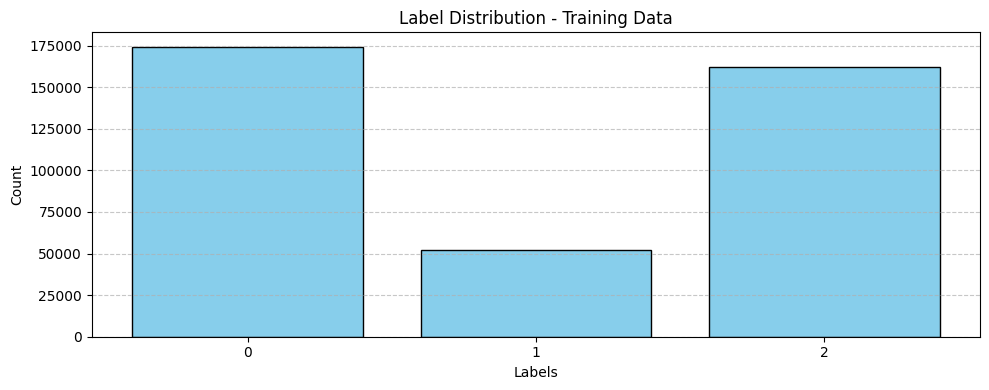

In [15]:
# Checking the label distribution of training data
print('\n\n====== Label Distribution - Training data ======')
unique_labels, counts = np.unique(y_train, return_counts=True)
total = counts.sum()
print(f"{'Label':<10}{'Count':<10}{'Percentage':<10}")
print("-" * 30)
for label, count in zip(unique_labels, counts):
    percentage = (count / total) * 100
    print(f"{label:<10}{count:<10}{percentage:<.2f}%")

print(f"\nTotal samples: {total}")

# Plot histogram for training data
unique_labels, counts = np.unique(y_train, return_counts=True)
plt.figure(figsize=(10, 4))
plt.bar(unique_labels.astype(str), counts, color='skyblue', edgecolor='black')
plt.xlabel("Labels")
plt.ylabel("Count")
plt.title(f"Label Distribution - Training Data")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

## Dataset and DataLoader

In [16]:
class Conv1dDataset(Dataset):
    def __init__(self, X, y):
        """
        X expected shape: (N, T, F)  -> convert to (N, C, L) with C=F, L=T
        Transpose to (N, F, T)
        """
        self.X = torch.tensor(X.transpose(0, 2, 1), dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [17]:
train_dataset = Conv1dDataset(X_train, y_train)
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

val_dataset = Conv1dDataset(X_val, y_val)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

test_dataset = Conv1dDataset(X_test, y_test)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

## Model

In [18]:
# Blocks (Conv + FC) 
# ----------------------------
class Conv1d_BayesBlock(ModuleWrapperConv1d):
    """BBBConv1d + BN + ReLU inside a Conv1d wrapper"""
    def __init__(self, in_ch, out_ch, kernel_size, priors, device='cpu', padding=0):
        super().__init__()
        self.conv = BayesianConv1d(in_ch, out_ch, kernel_size, padding=padding, priors=priors, device=device)
        self.bn = nn.BatchNorm1d(out_ch)
        self.act = nn.ReLU()

class FCBayesBlock(ModuleWrapperLinear):
    """BBBLinear (optionally add activation if you want)"""
    def __init__(self, in_f, out_f, priors, device='cpu'):
        super().__init__()
        self.fc = BayesianLinear(in_f, out_f, priors=priors, device=device)

In [19]:
########################################
# Bayesian CNN + FC Model
########################################
class BayesianCNN_FC(nn.Module):
    def __init__(self, in_channels=6,  num_classes=3, priors=None, device='cpu'):
        super().__init__()
        self.device = device
        self.conv1 = Conv1d_BayesBlock(in_channels, 64, 5, priors, device=device, padding=2)
        self.conv2 = Conv1d_BayesBlock(64, 128, 5, priors, device=device, padding=2)
        self.conv3 = Conv1d_BayesBlock(128, 256, 5, priors, device=device, padding=2)
        self.conv4 = Conv1d_BayesBlock(256, 512, 5, priors, device=device, padding=2)
        self.conv5 = Conv1d_BayesBlock(512, 1024, 5, priors, device=device, padding=2)
        self.global_pool = nn.AdaptiveAvgPool1d(1)
        self.fc = FCBayesBlock(1024, num_classes, priors, device=device)

    def forward(self, x, sample=True, n_samples=1):
        # x: (batch, channels, length)  OR  (n_samples, batch, channels, length)
        kl_total = torch.tensor(0.0, device=x.device)

        x, kl = self.conv1(x, sample=sample, n_samples=n_samples); kl_total += kl
        x, kl = self.conv2(x, sample=sample, n_samples=n_samples); kl_total += kl
        x, kl = self.conv3(x, sample=sample, n_samples=n_samples); kl_total += kl
        x, kl = self.conv4(x, sample=sample, n_samples=n_samples); kl_total += kl
        x, kl = self.conv5(x, sample=sample, n_samples=n_samples); kl_total += kl

        # global pool (handle sample dim)
        if x.dim() == 4:  # (T, B, C, L)
            T_, B_, C_, L_ = x.shape
            x = x.reshape(T_ * B_, C_, L_)
            x = self.global_pool(x)             # (T*B, C, 1)
            x = x.squeeze(-1)                   # (T*B, C)
            x = x.reshape(T_, B_, C_)           # (T, B, C)
        elif x.dim() == 3:  # (B, C, L)
            x = self.global_pool(x)             # (B, C, 1)
            x = x.squeeze(-1)                   # (B, C)
        else:
            raise ValueError(f"Unexpected shape: {x.shape}")

        x, kl_fc = self.fc(x, sample=sample, n_samples=n_samples)
        kl_total += kl_fc

        return x, kl_total

In [20]:
########################################
# Model Initialization
########################################
if not flag_subsampled:
    model = BayesianCNN_FC(in_channels=6, num_classes=3, priors=PRIORS, device=DEVICE).to(DEVICE)
    model = torch.compile(model, backend='eager')
    print(model)
    
    # Loading model trained on SiteA-2019
    checkpoint = torch.load("/kaggle/input/bcnn/pytorch/default/1/BCNN.pth", map_location=torch.device("cpu"))
    model.load_state_dict(checkpoint)

## Evaluation Function

In [21]:
def compute_accuracy_per_sample_mean(outputs, labels):
    """
    outputs: (T, B, C) or (B, C)
    """
    if outputs.dim() == 3:
        preds = outputs.argmax(dim=2)               # (T, B)
        eq = (preds == labels.unsqueeze(0))         # (T, B)
        return eq.float().mean(dim=1).mean().item() # avg over T, then scalar
    else:
        preds = outputs.argmax(dim=1)
        return (preds == labels).float().mean().item()

In [22]:
def evaluate(model, dataloader, T, device):
    sample_flag = (T > 1)
    
    all_preds = []
    all_labels = []
    total_acc = 0.0

    model.eval()
    with torch.no_grad():
        for x_batch, y_batch in tqdm(dataloader, desc=f"Stochastic Validation (T={T})" if sample_flag else f"Deterministic Validation (T={T})"):
            x_batch = x_batch.to(device)
            y_batch = y_batch.to(device)

            
            outputs, _ = model(x_batch, sample=sample_flag, n_samples=T)  # (T,B,C) or (B,C)

            # Accuracy before averaging predictions
            total_acc += compute_accuracy_per_sample_mean(outputs, y_batch) * x_batch.size(0)

            # Average over stochastic passes if T>1
            if sample_flag and outputs.dim() == 3:
                outputs = outputs.mean(dim=0)  # (B, C)

            # Get predictions
            probs = torch.softmax(outputs, dim=1)  # (B, C)
            preds = torch.argmax(probs, dim=1)

            all_preds.append(preds.cpu())
            all_labels.append(y_batch.cpu())

    all_preds = torch.cat(all_preds)
    all_labels = torch.cat(all_labels)

    # ====== Metrics ======
    kappa = cohen_kappa_score(all_labels.numpy(), all_preds.numpy())
    per_class_f1 = f1_score(all_labels.numpy(), all_preds.numpy(), average=None)
    avg_f1 = f1_score(all_labels.numpy(), all_preds.numpy(), average="macro")
    acc = total_acc / len(dataloader.dataset)
    cm = confusion_matrix(all_labels, all_preds)

    return acc, kappa, per_class_f1, avg_f1, cm

In [23]:
# acc, kappa, per_class_f1, avg_f1, cm = evaluate(model, test_dataloader, T, device=DEVICE)

# # Printing and plotting
# print("Stochastic" + f" Accuracy (mean over T): {acc:.4f}" if (T>1) else "Deterministic" + f" Accuracy (mean over T): {acc:.4f}")
# print(f"Cohen's Kappa: {kappa:.4f}")
# print(f"Per-class F1: {per_class_f1}")
# print(f"Average F1 (macro): {avg_f1:.4f}")

# disp = ConfusionMatrixDisplay(confusion_matrix=cm)
# disp.plot(cmap="Blues")
# plt.title(f"Confusion Matrix - Site {SITE} - {YEAR}")
# plt.tight_layout()
# plt.show()

## Training Loop

In [24]:
# ===== Class weights =====
all_labels = []
for _, y_batch in train_dataloader:
    all_labels.append(y_batch.numpy())

all_labels = np.concatenate(all_labels)
classes = np.unique(all_labels)
class_weights_np = compute_class_weight(class_weight='balanced',
                                        classes=classes, y=all_labels)
class_weights = torch.tensor(class_weights_np, dtype=torch.float).to(DEVICE)
class_weights = torch.clamp(class_weights, max=1.25) # Clipping to max 1.00
print("Class weights:", class_weights)

Class weights: tensor([0.7438, 1.2500, 0.7980], device='cuda:0')


In [25]:
# ===== Optimizer =====
if not flag_subsampled:
    optimizer = torch.optim.Adam(model.parameters(), lr=LR)

In [26]:
def ELBO_loss_nll_from_logits(outputs, y_batch, class_weights=None):
    """
    outputs: (T, B, C) or (B, C)
    y_batch: (B,)
    """
    if outputs.dim() == 3:
        T, B, C = outputs.shape
        outputs_flat = outputs.reshape(T * B, C)
        labels_rep = y_batch.unsqueeze(0).expand(T, B).reshape(T * B)
        return F.cross_entropy(outputs_flat, labels_rep,
                               weight=class_weights, reduction='mean')
    else:
        return F.cross_entropy(outputs, y_batch,
                               weight=class_weights, reduction='mean')

In [27]:
# ===== Training Loop =====
def train(model, train_dataset, train_loader, val_loader, optimizer, KL_WEIGHT=1e-8, EPOCHS=15, T=15):
    train_losses, val_losses = [], []
    train_accs, val_accs = [], []
    
    for epoch in range(EPOCHS):
        # === TRAIN ===
        model.train()
        train_loss = 0.0
        train_acc = 0.0
    
        for x_batch, y_batch in tqdm(train_loader, desc=f'Training Epoch {epoch+1}'):
            x_batch = x_batch.to(DEVICE)
            y_batch = y_batch.to(DEVICE)
    
            optimizer.zero_grad()
    
            # Forward pass with T stochastic samples
            outputs, kl = model(x_batch, sample=True, n_samples=T)  # (T,B,C) + scalar KL
    
            # Mean NLL across T samples
            nll_mean = ELBO_loss_nll_from_logits(outputs, y_batch, class_weights)
            
            # ELBO Loss
            loss = nll_mean + KL_WEIGHT * kl
    
            # Backprop
            loss.backward()
            optimizer.step()
    
            # Stats
            train_loss += loss.item() * x_batch.size(0)
            train_acc += compute_accuracy_per_sample_mean(outputs, y_batch) * x_batch.size(0)
    
        train_loss /= len(train_dataset)
        train_acc /= len(train_dataset)
        print(f'Loss: {nll_mean:.4f} + {KL_WEIGHT} * {kl}')
    
        # === VALIDATION ===
        model.eval()
        val_loss = 0.0
        val_acc = 0.0
    
        with torch.no_grad():
            for x_batch, y_batch in tqdm(val_loader, desc='Validation'):
                x_batch = x_batch.to(DEVICE)
                y_batch = y_batch.to(DEVICE)
    
                outputs, kl = model(x_batch, sample=False, n_samples=1)  # deterministic eval
                nll = ELBO_loss_nll_from_logits(outputs, y_batch, class_weights)
                loss = nll + KL_WEIGHT * kl
    
                val_loss += loss.item() * x_batch.size(0)
                val_acc += compute_accuracy_per_sample_mean(outputs, y_batch) * x_batch.size(0)
    
        val_loss /= len(val_dataset)
        val_acc /= len(val_dataset)
    
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accs.append(train_acc)
        val_accs.append(val_acc)
    
        print(f"Epoch [{epoch+1}/{EPOCHS}] "
              f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f} | "
              f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}") 

    return train_losses, val_losses, train_accs, val_accs

In [28]:
# Subsampled Training
def subsampled_training(X_train, y_train, val_dataloader, start, end, step):
    subset_sizes = list(range(start, end+1, step))
    print(subset_sizes)
    
    elbow_history = {
        "subset_size": [],
        "train_accuracy": [],
        "train_loss": [],
        "val_accuracy": [],
        "val_loss": [],
        "val_avg_f1": [],
        "kappa": []
    }
    
    for size in subset_sizes:
        print(f"\nTraining with {size} samples...")
        
        subset_indices = np.arange(size)
        X_subsample = X_train[subset_indices]
        y_subsample = y_train[subset_indices]
    
        # Create dataset & dataloader
        subsample_dataset = Conv1dDataset(X_subsample, y_subsample)
        subsample_loader = DataLoader(subsample_dataset, batch_size=BATCH_SIZE, shuffle=True)
    
        # Fresh model for each subset and optimizer
        model = BayesianCNN_FC(in_channels=6, num_classes=3, priors=PRIORS, device=DEVICE).to(DEVICE)
        model = torch.compile(model, backend='eager')
        checkpoint = torch.load("/kaggle/input/bcnn/pytorch/default/1/BCNN.pth", map_location=torch.device("cpu"))
        model.load_state_dict(checkpoint)
        optimizer = torch.optim.Adam(model.parameters(), lr=LR)  
    
        # Train
        train_losses, val_losses, train_accs, val_accs = train(model, subsample_dataset, subsample_loader, val_dataloader, optimizer, KL_WEIGHT=KL_WEIGHT, EPOCHS=EPOCHS, T=T)
        # Evaluate
        acc, kappa, per_class_f1, avg_f1, cm = evaluate(model, test_dataloader, T, device=DEVICE)
    
        # Printing and plotting
        print("Stochastic" + f" Accuracy (mean over T): {acc:.4f}" if (T>1) else "Deterministic" + f" Accuracy (mean over T): {acc:.4f}")
        print(f"Cohen's Kappa: {kappa:.4f}")
        print(f"Per-class F1: {per_class_f1}")
        print(f"Average F1 (macro): {avg_f1:.4f}")
        
        disp = ConfusionMatrixDisplay(confusion_matrix=cm)
        disp.plot(cmap="Blues")
        plt.title(f"Confusion Matrix - Site {SITE} - {YEAR}")
        plt.tight_layout()
        plt.show()
        
        # Save final epoch stats
        elbow_history["subset_size"].append(size)
        elbow_history["train_loss"].append(train_losses[-1])
        elbow_history["train_accuracy"].append(train_accs[-1])
        elbow_history["val_accuracy"].append(val_accs[-1])
        elbow_history["val_loss"].append(val_losses[-1])
        elbow_history["val_avg_f1"].append(avg_f1)
        elbow_history["kappa"].append(kappa)

    return elbow_history

## Training

[1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000, 9000, 10000, 11000, 12000, 13000, 14000, 15000]

Training with 1000 samples...


Training Epoch 1: 100%|██████████| 16/16 [00:04<00:00,  3.49it/s]


Loss: 0.8318 + 1e-08 * 2864321.75


Validation: 100%|██████████| 1519/1519 [00:11<00:00, 129.86it/s]


Epoch [1/15] Train Loss: 1.3020, Train Acc: 0.6170 | Val Loss: 0.8122, Val Acc: 0.6755


Training Epoch 2: 100%|██████████| 16/16 [00:00<00:00, 43.29it/s]


Loss: 0.5549 + 1e-08 * 2868824.25


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 141.99it/s]


Epoch [2/15] Train Loss: 0.5657, Train Acc: 0.7820 | Val Loss: 0.5236, Val Acc: 0.7999


Training Epoch 3: 100%|██████████| 16/16 [00:00<00:00, 42.10it/s]


Loss: 0.6207 + 1e-08 * 2869835.25


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 141.79it/s]


Epoch [3/15] Train Loss: 0.4271, Train Acc: 0.8350 | Val Loss: 0.4631, Val Acc: 0.8312


Training Epoch 4: 100%|██████████| 16/16 [00:00<00:00, 43.33it/s]


Loss: 0.2935 + 1e-08 * 2869561.75


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 141.64it/s]


Epoch [4/15] Train Loss: 0.3794, Train Acc: 0.8570 | Val Loss: 0.4258, Val Acc: 0.8455


Training Epoch 5: 100%|██████████| 16/16 [00:00<00:00, 43.73it/s]


Loss: 0.2733 + 1e-08 * 2869234.5


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 141.89it/s]


Epoch [5/15] Train Loss: 0.3404, Train Acc: 0.8760 | Val Loss: 0.4121, Val Acc: 0.8518


Training Epoch 6: 100%|██████████| 16/16 [00:00<00:00, 44.16it/s]


Loss: 0.2862 + 1e-08 * 2868861.0


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 142.42it/s]


Epoch [6/15] Train Loss: 0.3138, Train Acc: 0.8870 | Val Loss: 0.3978, Val Acc: 0.8574


Training Epoch 7: 100%|██████████| 16/16 [00:00<00:00, 43.91it/s]


Loss: 0.2360 + 1e-08 * 2868292.0


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 141.99it/s]


Epoch [7/15] Train Loss: 0.2991, Train Acc: 0.8950 | Val Loss: 0.3925, Val Acc: 0.8601


Training Epoch 8: 100%|██████████| 16/16 [00:00<00:00, 43.52it/s]


Loss: 0.2155 + 1e-08 * 2867915.5


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 142.45it/s]


Epoch [8/15] Train Loss: 0.2819, Train Acc: 0.8910 | Val Loss: 0.3905, Val Acc: 0.8628


Training Epoch 9: 100%|██████████| 16/16 [00:00<00:00, 43.81it/s]


Loss: 0.1628 + 1e-08 * 2867622.5


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 143.52it/s]


Epoch [9/15] Train Loss: 0.2689, Train Acc: 0.9020 | Val Loss: 0.3863, Val Acc: 0.8635


Training Epoch 10: 100%|██████████| 16/16 [00:00<00:00, 44.19it/s]


Loss: 0.2366 + 1e-08 * 2867816.25


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 144.03it/s]


Epoch [10/15] Train Loss: 0.2518, Train Acc: 0.9190 | Val Loss: 0.3853, Val Acc: 0.8643


Training Epoch 11: 100%|██████████| 16/16 [00:00<00:00, 43.87it/s]


Loss: 0.2318 + 1e-08 * 2867861.75


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 143.58it/s]


Epoch [11/15] Train Loss: 0.2262, Train Acc: 0.9240 | Val Loss: 0.3905, Val Acc: 0.8653


Training Epoch 12: 100%|██████████| 16/16 [00:00<00:00, 43.92it/s]


Loss: 0.1070 + 1e-08 * 2868701.25


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 142.44it/s]


Epoch [12/15] Train Loss: 0.2084, Train Acc: 0.9340 | Val Loss: 0.3953, Val Acc: 0.8628


Training Epoch 13: 100%|██████████| 16/16 [00:00<00:00, 42.88it/s]


Loss: 0.1693 + 1e-08 * 2868993.0


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 143.03it/s]


Epoch [13/15] Train Loss: 0.1952, Train Acc: 0.9380 | Val Loss: 0.3938, Val Acc: 0.8640


Training Epoch 14: 100%|██████████| 16/16 [00:00<00:00, 44.60it/s]


Loss: 0.2034 + 1e-08 * 2869605.75


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 143.16it/s]


Epoch [14/15] Train Loss: 0.1814, Train Acc: 0.9440 | Val Loss: 0.4022, Val Acc: 0.8638


Training Epoch 15: 100%|██████████| 16/16 [00:00<00:00, 44.24it/s]


Loss: 0.1478 + 1e-08 * 2870435.75


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 143.94it/s]


Epoch [15/15] Train Loss: 0.1725, Train Acc: 0.9540 | Val Loss: 0.4080, Val Acc: 0.8636


Stochastic Validation (T=15): 100%|██████████| 22778/22778 [02:44<00:00, 138.80it/s]


Stochastic Accuracy (mean over T): 0.8641
Cohen's Kappa: 0.7754
Per-class F1: [0.861847   0.88280963 0.86065785]
Average F1 (macro): 0.8684


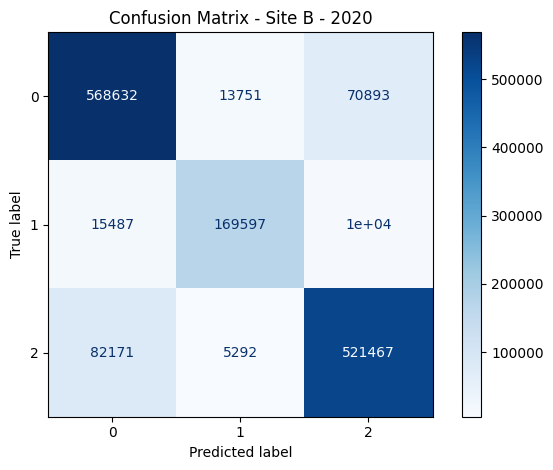


Training with 2000 samples...


Training Epoch 1: 100%|██████████| 32/32 [00:00<00:00, 42.01it/s]


Loss: 0.6901 + 1e-08 * 2869216.5


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 138.78it/s]


Epoch [1/15] Train Loss: 0.9828, Train Acc: 0.7015 | Val Loss: 0.5531, Val Acc: 0.7943


Training Epoch 2: 100%|██████████| 32/32 [00:00<00:00, 42.83it/s]


Loss: 0.5360 + 1e-08 * 2870561.75


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 139.17it/s]


Epoch [2/15] Train Loss: 0.4254, Train Acc: 0.8430 | Val Loss: 0.4199, Val Acc: 0.8481


Training Epoch 3: 100%|██████████| 32/32 [00:00<00:00, 43.55it/s]


Loss: 0.1355 + 1e-08 * 2869619.75


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 139.64it/s]


Epoch [3/15] Train Loss: 0.3573, Train Acc: 0.8715 | Val Loss: 0.3896, Val Acc: 0.8580


Training Epoch 4: 100%|██████████| 32/32 [00:00<00:00, 43.41it/s]


Loss: 0.2545 + 1e-08 * 2868732.75


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 140.09it/s]


Epoch [4/15] Train Loss: 0.3309, Train Acc: 0.8770 | Val Loss: 0.3737, Val Acc: 0.8654


Training Epoch 5: 100%|██████████| 32/32 [00:00<00:00, 43.34it/s]


Loss: 0.1214 + 1e-08 * 2868238.75


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 140.24it/s]


Epoch [5/15] Train Loss: 0.3099, Train Acc: 0.8845 | Val Loss: 0.3680, Val Acc: 0.8705


Training Epoch 6: 100%|██████████| 32/32 [00:00<00:00, 43.19it/s]


Loss: 0.4301 + 1e-08 * 2866449.5


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 140.75it/s]


Epoch [6/15] Train Loss: 0.2872, Train Acc: 0.8995 | Val Loss: 0.3605, Val Acc: 0.8730


Training Epoch 7: 100%|██████████| 32/32 [00:00<00:00, 43.35it/s]


Loss: 0.6452 + 1e-08 * 2866656.25


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 141.28it/s]


Epoch [7/15] Train Loss: 0.2764, Train Acc: 0.9030 | Val Loss: 0.3590, Val Acc: 0.8733


Training Epoch 8: 100%|██████████| 32/32 [00:00<00:00, 43.35it/s]


Loss: 0.3587 + 1e-08 * 2865763.25


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 142.34it/s]


Epoch [8/15] Train Loss: 0.2413, Train Acc: 0.9140 | Val Loss: 0.3596, Val Acc: 0.8713


Training Epoch 9: 100%|██████████| 32/32 [00:00<00:00, 43.71it/s]


Loss: 0.1777 + 1e-08 * 2865888.0


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 141.82it/s]


Epoch [9/15] Train Loss: 0.2290, Train Acc: 0.9235 | Val Loss: 0.3632, Val Acc: 0.8750


Training Epoch 10: 100%|██████████| 32/32 [00:00<00:00, 43.46it/s]


Loss: 0.2267 + 1e-08 * 2865553.5


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 141.86it/s]


Epoch [10/15] Train Loss: 0.2259, Train Acc: 0.9270 | Val Loss: 0.3667, Val Acc: 0.8730


Training Epoch 11: 100%|██████████| 32/32 [00:00<00:00, 44.12it/s]


Loss: 0.2022 + 1e-08 * 2867010.0


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 142.13it/s]


Epoch [11/15] Train Loss: 0.2071, Train Acc: 0.9310 | Val Loss: 0.3763, Val Acc: 0.8709


Training Epoch 12: 100%|██████████| 32/32 [00:00<00:00, 43.98it/s]


Loss: 0.1580 + 1e-08 * 2868675.0


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 142.49it/s]


Epoch [12/15] Train Loss: 0.1970, Train Acc: 0.9360 | Val Loss: 0.3899, Val Acc: 0.8653


Training Epoch 13: 100%|██████████| 32/32 [00:00<00:00, 43.78it/s]


Loss: 0.0404 + 1e-08 * 2870082.5


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 142.78it/s]


Epoch [13/15] Train Loss: 0.1770, Train Acc: 0.9480 | Val Loss: 0.3861, Val Acc: 0.8738


Training Epoch 14: 100%|██████████| 32/32 [00:00<00:00, 43.74it/s]


Loss: 0.1691 + 1e-08 * 2872467.0


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 142.38it/s]


Epoch [14/15] Train Loss: 0.1698, Train Acc: 0.9435 | Val Loss: 0.3896, Val Acc: 0.8709


Training Epoch 15: 100%|██████████| 32/32 [00:00<00:00, 43.16it/s]


Loss: 0.3160 + 1e-08 * 2874540.25


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 142.64it/s]


Epoch [15/15] Train Loss: 0.1557, Train Acc: 0.9510 | Val Loss: 0.4111, Val Acc: 0.8680


Stochastic Validation (T=15): 100%|██████████| 22778/22778 [02:44<00:00, 138.17it/s]


Stochastic Accuracy (mean over T): 0.8687
Cohen's Kappa: 0.7827
Per-class F1: [0.86666196 0.89131643 0.86388184]
Average F1 (macro): 0.8740


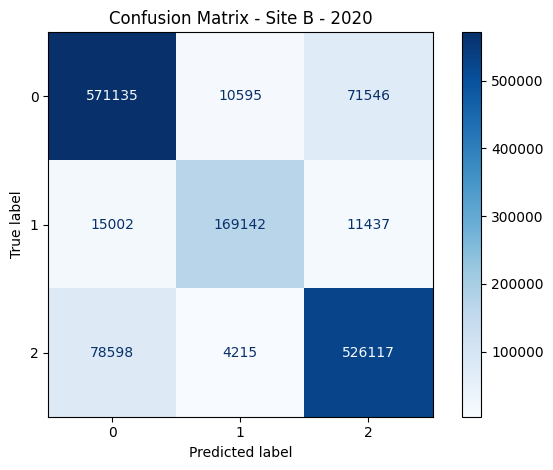


Training with 3000 samples...


Training Epoch 1: 100%|██████████| 47/47 [00:01<00:00, 42.78it/s]


Loss: 0.3593 + 1e-08 * 2868750.75


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 141.15it/s]


Epoch [1/15] Train Loss: 0.8390, Train Acc: 0.7377 | Val Loss: 0.4540, Val Acc: 0.8321


Training Epoch 2: 100%|██████████| 47/47 [00:01<00:00, 42.78it/s]


Loss: 0.2584 + 1e-08 * 2867948.0


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 141.09it/s]


Epoch [2/15] Train Loss: 0.3849, Train Acc: 0.8630 | Val Loss: 0.3915, Val Acc: 0.8603


Training Epoch 3: 100%|██████████| 47/47 [00:01<00:00, 42.72it/s]


Loss: 0.2268 + 1e-08 * 2866037.0


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 140.83it/s]


Epoch [3/15] Train Loss: 0.3375, Train Acc: 0.8770 | Val Loss: 0.3593, Val Acc: 0.8688


Training Epoch 4: 100%|██████████| 47/47 [00:01<00:00, 42.79it/s]


Loss: 0.2526 + 1e-08 * 2862797.5


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 140.85it/s]


Epoch [4/15] Train Loss: 0.3059, Train Acc: 0.8897 | Val Loss: 0.3561, Val Acc: 0.8744


Training Epoch 5: 100%|██████████| 47/47 [00:01<00:00, 43.19it/s]


Loss: 0.3367 + 1e-08 * 2860103.0


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 142.01it/s]


Epoch [5/15] Train Loss: 0.2866, Train Acc: 0.9043 | Val Loss: 0.3471, Val Acc: 0.8736


Training Epoch 6: 100%|██████████| 47/47 [00:01<00:00, 43.13it/s]


Loss: 0.2350 + 1e-08 * 2858038.5


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 142.46it/s]


Epoch [6/15] Train Loss: 0.2725, Train Acc: 0.9040 | Val Loss: 0.3526, Val Acc: 0.8742


Training Epoch 7: 100%|██████████| 47/47 [00:01<00:00, 43.33it/s]


Loss: 0.4868 + 1e-08 * 2856790.75


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 142.19it/s]


Epoch [7/15] Train Loss: 0.2521, Train Acc: 0.9190 | Val Loss: 0.3411, Val Acc: 0.8788


Training Epoch 8: 100%|██████████| 47/47 [00:01<00:00, 42.81it/s]


Loss: 0.2270 + 1e-08 * 2855647.0


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 142.11it/s]


Epoch [8/15] Train Loss: 0.2393, Train Acc: 0.9210 | Val Loss: 0.3456, Val Acc: 0.8789


Training Epoch 9: 100%|██████████| 47/47 [00:01<00:00, 43.30it/s]


Loss: 0.1834 + 1e-08 * 2854591.5


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 142.47it/s]


Epoch [9/15] Train Loss: 0.2183, Train Acc: 0.9273 | Val Loss: 0.3530, Val Acc: 0.8780


Training Epoch 10: 100%|██████████| 47/47 [00:01<00:00, 43.34it/s]


Loss: 0.1187 + 1e-08 * 2855414.0


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 141.40it/s]


Epoch [10/15] Train Loss: 0.2082, Train Acc: 0.9323 | Val Loss: 0.3538, Val Acc: 0.8777


Training Epoch 11: 100%|██████████| 47/47 [00:01<00:00, 43.27it/s]


Loss: 0.1306 + 1e-08 * 2856244.5


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 142.31it/s]


Epoch [11/15] Train Loss: 0.1952, Train Acc: 0.9403 | Val Loss: 0.3624, Val Acc: 0.8754


Training Epoch 12: 100%|██████████| 47/47 [00:01<00:00, 43.35it/s]


Loss: 0.2029 + 1e-08 * 2857136.0


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 142.03it/s]


Epoch [12/15] Train Loss: 0.1823, Train Acc: 0.9430 | Val Loss: 0.3668, Val Acc: 0.8775


Training Epoch 13: 100%|██████████| 47/47 [00:01<00:00, 43.26it/s]


Loss: 0.1191 + 1e-08 * 2858891.25


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 142.11it/s]


Epoch [13/15] Train Loss: 0.1634, Train Acc: 0.9510 | Val Loss: 0.3838, Val Acc: 0.8757


Training Epoch 14: 100%|██████████| 47/47 [00:01<00:00, 43.30it/s]


Loss: 0.1190 + 1e-08 * 2861334.75


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 141.66it/s]


Epoch [14/15] Train Loss: 0.1545, Train Acc: 0.9557 | Val Loss: 0.4020, Val Acc: 0.8735


Training Epoch 15: 100%|██████████| 47/47 [00:01<00:00, 42.63it/s]


Loss: 0.1571 + 1e-08 * 2863965.5


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 140.71it/s]


Epoch [15/15] Train Loss: 0.1440, Train Acc: 0.9583 | Val Loss: 0.3969, Val Acc: 0.8763


Stochastic Validation (T=15): 100%|██████████| 22778/22778 [02:45<00:00, 137.38it/s]


Stochastic Accuracy (mean over T): 0.8772
Cohen's Kappa: 0.7973
Per-class F1: [0.87386579 0.8929364  0.87566072]
Average F1 (macro): 0.8808


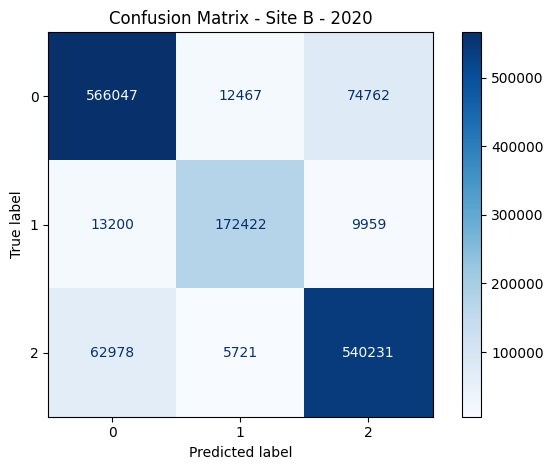


Training with 4000 samples...


Training Epoch 1: 100%|██████████| 63/63 [00:01<00:00, 42.60it/s]


Loss: 0.3913 + 1e-08 * 2869856.25


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 139.62it/s]


Epoch [1/15] Train Loss: 0.7405, Train Acc: 0.7620 | Val Loss: 0.4231, Val Acc: 0.8450


Training Epoch 2: 100%|██████████| 63/63 [00:01<00:00, 43.03it/s]


Loss: 0.3698 + 1e-08 * 2866968.0


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 140.25it/s]


Epoch [2/15] Train Loss: 0.3847, Train Acc: 0.8588 | Val Loss: 0.3652, Val Acc: 0.8668


Training Epoch 3: 100%|██████████| 63/63 [00:01<00:00, 44.02it/s]


Loss: 0.2291 + 1e-08 * 2863201.75


Validation: 100%|██████████| 1519/1519 [00:11<00:00, 138.06it/s]


Epoch [3/15] Train Loss: 0.3353, Train Acc: 0.8775 | Val Loss: 0.3467, Val Acc: 0.8748


Training Epoch 4: 100%|██████████| 63/63 [00:01<00:00, 42.88it/s]


Loss: 0.1793 + 1e-08 * 2858787.5


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 139.47it/s]


Epoch [4/15] Train Loss: 0.3142, Train Acc: 0.8840 | Val Loss: 0.3400, Val Acc: 0.8791


Training Epoch 5: 100%|██████████| 63/63 [00:01<00:00, 43.08it/s]


Loss: 0.2249 + 1e-08 * 2854794.0


Validation: 100%|██████████| 1519/1519 [00:11<00:00, 137.55it/s]


Epoch [5/15] Train Loss: 0.2870, Train Acc: 0.8965 | Val Loss: 0.3315, Val Acc: 0.8808


Training Epoch 6: 100%|██████████| 63/63 [00:01<00:00, 43.04it/s]


Loss: 0.1505 + 1e-08 * 2850877.5


Validation: 100%|██████████| 1519/1519 [00:11<00:00, 134.61it/s]


Epoch [6/15] Train Loss: 0.2735, Train Acc: 0.9045 | Val Loss: 0.3310, Val Acc: 0.8820


Training Epoch 7: 100%|██████████| 63/63 [00:01<00:00, 42.50it/s]


Loss: 0.4122 + 1e-08 * 2848293.0


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 138.97it/s]


Epoch [7/15] Train Loss: 0.2603, Train Acc: 0.9097 | Val Loss: 0.3328, Val Acc: 0.8823


Training Epoch 8: 100%|██████████| 63/63 [00:01<00:00, 43.15it/s]


Loss: 0.2534 + 1e-08 * 2847449.75


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 138.87it/s]


Epoch [8/15] Train Loss: 0.2455, Train Acc: 0.9160 | Val Loss: 0.3276, Val Acc: 0.8850


Training Epoch 9: 100%|██████████| 63/63 [00:01<00:00, 42.44it/s]


Loss: 0.1679 + 1e-08 * 2846658.5


Validation: 100%|██████████| 1519/1519 [00:11<00:00, 135.33it/s]


Epoch [9/15] Train Loss: 0.2302, Train Acc: 0.9225 | Val Loss: 0.3278, Val Acc: 0.8836


Training Epoch 10: 100%|██████████| 63/63 [00:01<00:00, 41.85it/s]


Loss: 0.2963 + 1e-08 * 2845873.75


Validation: 100%|██████████| 1519/1519 [00:11<00:00, 130.87it/s]


Epoch [10/15] Train Loss: 0.2144, Train Acc: 0.9340 | Val Loss: 0.3436, Val Acc: 0.8803


Training Epoch 11: 100%|██████████| 63/63 [00:01<00:00, 41.21it/s]


Loss: 0.0553 + 1e-08 * 2847468.75


Validation: 100%|██████████| 1519/1519 [00:11<00:00, 127.52it/s]


Epoch [11/15] Train Loss: 0.1966, Train Acc: 0.9393 | Val Loss: 0.3478, Val Acc: 0.8811


Training Epoch 12: 100%|██████████| 63/63 [00:01<00:00, 39.07it/s]


Loss: 0.2969 + 1e-08 * 2849013.75


Validation: 100%|██████████| 1519/1519 [00:12<00:00, 125.64it/s]


Epoch [12/15] Train Loss: 0.1887, Train Acc: 0.9390 | Val Loss: 0.3525, Val Acc: 0.8828


Training Epoch 13: 100%|██████████| 63/63 [00:01<00:00, 39.79it/s]


Loss: 0.3402 + 1e-08 * 2852765.75


Validation: 100%|██████████| 1519/1519 [00:12<00:00, 125.75it/s]


Epoch [13/15] Train Loss: 0.1846, Train Acc: 0.9387 | Val Loss: 0.3535, Val Acc: 0.8841


Training Epoch 14: 100%|██████████| 63/63 [00:01<00:00, 40.37it/s]


Loss: 0.1348 + 1e-08 * 2857385.0


Validation: 100%|██████████| 1519/1519 [00:12<00:00, 122.89it/s]


Epoch [14/15] Train Loss: 0.1642, Train Acc: 0.9507 | Val Loss: 0.3743, Val Acc: 0.8774


Training Epoch 15: 100%|██████████| 63/63 [00:01<00:00, 39.25it/s]


Loss: 0.0787 + 1e-08 * 2862814.5


Validation: 100%|██████████| 1519/1519 [00:12<00:00, 122.95it/s]


Epoch [15/15] Train Loss: 0.1509, Train Acc: 0.9545 | Val Loss: 0.3808, Val Acc: 0.8785


Stochastic Validation (T=15): 100%|██████████| 22778/22778 [03:06<00:00, 121.81it/s]


Stochastic Accuracy (mean over T): 0.8791
Cohen's Kappa: 0.7999
Per-class F1: [0.87763017 0.89990936 0.87425936]
Average F1 (macro): 0.8839


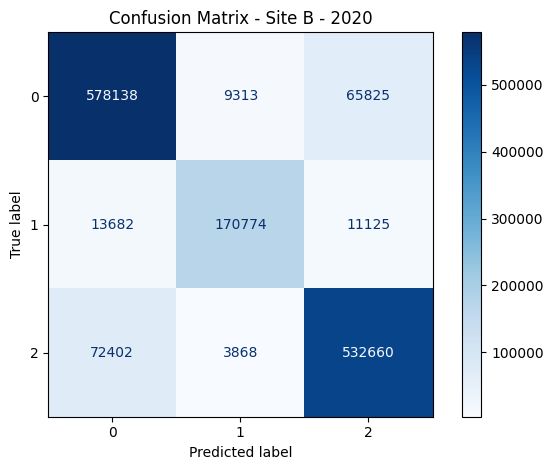


Training with 5000 samples...


Training Epoch 1: 100%|██████████| 79/79 [00:01<00:00, 39.65it/s]


Loss: 0.4974 + 1e-08 * 2869853.5


Validation: 100%|██████████| 1519/1519 [00:12<00:00, 125.42it/s]


Epoch [1/15] Train Loss: 0.6661, Train Acc: 0.7804 | Val Loss: 0.4043, Val Acc: 0.8533


Training Epoch 2: 100%|██████████| 79/79 [00:01<00:00, 40.43it/s]


Loss: 0.4373 + 1e-08 * 2865260.5


Validation: 100%|██████████| 1519/1519 [00:11<00:00, 126.59it/s]


Epoch [2/15] Train Loss: 0.3627, Train Acc: 0.8640 | Val Loss: 0.3492, Val Acc: 0.8726


Training Epoch 3: 100%|██████████| 79/79 [00:01<00:00, 40.44it/s]


Loss: 0.1526 + 1e-08 * 2860388.75


Validation: 100%|██████████| 1519/1519 [00:11<00:00, 126.63it/s]


Epoch [3/15] Train Loss: 0.3280, Train Acc: 0.8834 | Val Loss: 0.3339, Val Acc: 0.8799


Training Epoch 4: 100%|██████████| 79/79 [00:01<00:00, 40.49it/s]


Loss: 0.3122 + 1e-08 * 2854184.0


Validation: 100%|██████████| 1519/1519 [00:12<00:00, 125.91it/s]


Epoch [4/15] Train Loss: 0.3067, Train Acc: 0.8880 | Val Loss: 0.3279, Val Acc: 0.8837


Training Epoch 5: 100%|██████████| 79/79 [00:01<00:00, 39.72it/s]


Loss: 0.1958 + 1e-08 * 2850296.0


Validation: 100%|██████████| 1519/1519 [00:12<00:00, 125.35it/s]


Epoch [5/15] Train Loss: 0.2868, Train Acc: 0.8996 | Val Loss: 0.3315, Val Acc: 0.8796


Training Epoch 6: 100%|██████████| 79/79 [00:01<00:00, 40.12it/s]


Loss: 0.3638 + 1e-08 * 2846880.75


Validation: 100%|██████████| 1519/1519 [00:12<00:00, 126.08it/s]


Epoch [6/15] Train Loss: 0.2675, Train Acc: 0.9068 | Val Loss: 0.3207, Val Acc: 0.8871


Training Epoch 7: 100%|██████████| 79/79 [00:01<00:00, 40.26it/s]


Loss: 0.5572 + 1e-08 * 2842688.25


Validation: 100%|██████████| 1519/1519 [00:12<00:00, 124.84it/s]


Epoch [7/15] Train Loss: 0.2517, Train Acc: 0.9138 | Val Loss: 0.3143, Val Acc: 0.8898


Training Epoch 8: 100%|██████████| 79/79 [00:01<00:00, 40.33it/s]


Loss: 0.3210 + 1e-08 * 2840772.25


Validation: 100%|██████████| 1519/1519 [00:12<00:00, 125.91it/s]


Epoch [8/15] Train Loss: 0.2425, Train Acc: 0.9140 | Val Loss: 0.3256, Val Acc: 0.8876


Training Epoch 9: 100%|██████████| 79/79 [00:01<00:00, 40.28it/s]


Loss: 0.4013 + 1e-08 * 2839972.75


Validation: 100%|██████████| 1519/1519 [00:12<00:00, 125.87it/s]


Epoch [9/15] Train Loss: 0.2286, Train Acc: 0.9220 | Val Loss: 0.3162, Val Acc: 0.8887


Training Epoch 10: 100%|██████████| 79/79 [00:01<00:00, 39.57it/s]


Loss: 0.2686 + 1e-08 * 2841106.25


Validation: 100%|██████████| 1519/1519 [00:12<00:00, 125.90it/s]


Epoch [10/15] Train Loss: 0.2150, Train Acc: 0.9268 | Val Loss: 0.3223, Val Acc: 0.8892


Training Epoch 11: 100%|██████████| 79/79 [00:01<00:00, 40.31it/s]


Loss: 0.1449 + 1e-08 * 2842400.75


Validation: 100%|██████████| 1519/1519 [00:12<00:00, 125.79it/s]


Epoch [11/15] Train Loss: 0.2069, Train Acc: 0.9304 | Val Loss: 0.3352, Val Acc: 0.8870


Training Epoch 12: 100%|██████████| 79/79 [00:01<00:00, 40.34it/s]


Loss: 0.0249 + 1e-08 * 2844342.25


Validation: 100%|██████████| 1519/1519 [00:12<00:00, 126.12it/s]


Epoch [12/15] Train Loss: 0.1861, Train Acc: 0.9410 | Val Loss: 0.3330, Val Acc: 0.8873


Training Epoch 13: 100%|██████████| 79/79 [00:01<00:00, 40.26it/s]


Loss: 0.0445 + 1e-08 * 2846760.25


Validation: 100%|██████████| 1519/1519 [00:12<00:00, 125.88it/s]


Epoch [13/15] Train Loss: 0.1737, Train Acc: 0.9430 | Val Loss: 0.3562, Val Acc: 0.8828


Training Epoch 14: 100%|██████████| 79/79 [00:01<00:00, 39.97it/s]


Loss: 0.0548 + 1e-08 * 2850649.25


Validation: 100%|██████████| 1519/1519 [00:12<00:00, 125.14it/s]


Epoch [14/15] Train Loss: 0.1659, Train Acc: 0.9494 | Val Loss: 0.3544, Val Acc: 0.8819


Training Epoch 15: 100%|██████████| 79/79 [00:01<00:00, 40.21it/s]


Loss: 0.2892 + 1e-08 * 2854899.25


Validation: 100%|██████████| 1519/1519 [00:12<00:00, 126.16it/s]


Epoch [15/15] Train Loss: 0.1528, Train Acc: 0.9546 | Val Loss: 0.3708, Val Acc: 0.8823


Stochastic Validation (T=15): 100%|██████████| 22778/22778 [03:03<00:00, 123.89it/s]


Stochastic Accuracy (mean over T): 0.8820
Cohen's Kappa: 0.8050
Per-class F1: [0.88159983 0.89706058 0.87773521]
Average F1 (macro): 0.8855


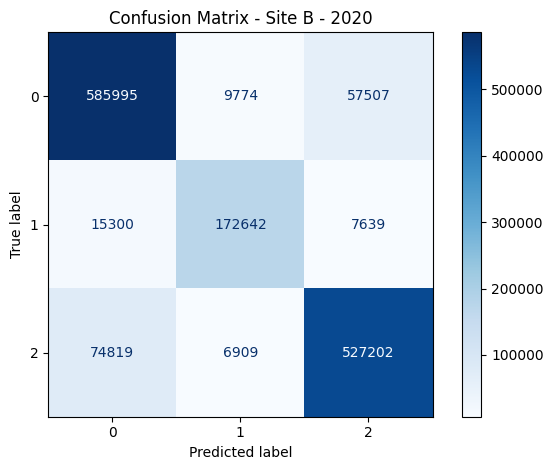


Training with 6000 samples...


Training Epoch 1: 100%|██████████| 94/94 [00:02<00:00, 39.74it/s]


Loss: 0.3978 + 1e-08 * 2870100.5


Validation: 100%|██████████| 1519/1519 [00:12<00:00, 125.47it/s]


Epoch [1/15] Train Loss: 0.6386, Train Acc: 0.7840 | Val Loss: 0.3811, Val Acc: 0.8581


Training Epoch 2: 100%|██████████| 94/94 [00:02<00:00, 39.54it/s]


Loss: 0.2588 + 1e-08 * 2865122.25


Validation: 100%|██████████| 1519/1519 [00:12<00:00, 122.98it/s]


Epoch [2/15] Train Loss: 0.3572, Train Acc: 0.8712 | Val Loss: 0.3493, Val Acc: 0.8739


Training Epoch 3: 100%|██████████| 94/94 [00:02<00:00, 39.81it/s]


Loss: 0.2061 + 1e-08 * 2857806.25


Validation: 100%|██████████| 1519/1519 [00:12<00:00, 125.04it/s]


Epoch [3/15] Train Loss: 0.3189, Train Acc: 0.8872 | Val Loss: 0.3292, Val Acc: 0.8817


Training Epoch 4: 100%|██████████| 94/94 [00:02<00:00, 40.38it/s]


Loss: 0.2796 + 1e-08 * 2850408.5


Validation: 100%|██████████| 1519/1519 [00:12<00:00, 125.68it/s]


Epoch [4/15] Train Loss: 0.2942, Train Acc: 0.8967 | Val Loss: 0.3194, Val Acc: 0.8860


Training Epoch 5: 100%|██████████| 94/94 [00:02<00:00, 39.73it/s]


Loss: 0.2412 + 1e-08 * 2843323.5


Validation: 100%|██████████| 1519/1519 [00:12<00:00, 124.83it/s]


Epoch [5/15] Train Loss: 0.2769, Train Acc: 0.9027 | Val Loss: 0.3170, Val Acc: 0.8863


Training Epoch 6: 100%|██████████| 94/94 [00:02<00:00, 39.97it/s]


Loss: 0.2476 + 1e-08 * 2837086.0


Validation: 100%|██████████| 1519/1519 [00:12<00:00, 125.86it/s]


Epoch [6/15] Train Loss: 0.2602, Train Acc: 0.9110 | Val Loss: 0.3274, Val Acc: 0.8806


Training Epoch 7: 100%|██████████| 94/94 [00:02<00:00, 39.93it/s]


Loss: 0.2331 + 1e-08 * 2833113.25


Validation: 100%|██████████| 1519/1519 [00:12<00:00, 125.74it/s]


Epoch [7/15] Train Loss: 0.2391, Train Acc: 0.9167 | Val Loss: 0.3162, Val Acc: 0.8885


Training Epoch 8: 100%|██████████| 94/94 [00:02<00:00, 40.05it/s]


Loss: 0.1779 + 1e-08 * 2832170.75


Validation: 100%|██████████| 1519/1519 [00:12<00:00, 125.32it/s]


Epoch [8/15] Train Loss: 0.2288, Train Acc: 0.9213 | Val Loss: 0.3209, Val Acc: 0.8860


Training Epoch 9: 100%|██████████| 94/94 [00:02<00:00, 40.37it/s]


Loss: 0.1945 + 1e-08 * 2830788.25


Validation: 100%|██████████| 1519/1519 [00:12<00:00, 125.27it/s]


Epoch [9/15] Train Loss: 0.2166, Train Acc: 0.9248 | Val Loss: 0.3148, Val Acc: 0.8911


Training Epoch 10: 100%|██████████| 94/94 [00:02<00:00, 39.70it/s]


Loss: 0.2899 + 1e-08 * 2832313.75


Validation: 100%|██████████| 1519/1519 [00:12<00:00, 124.98it/s]


Epoch [10/15] Train Loss: 0.2046, Train Acc: 0.9330 | Val Loss: 0.3266, Val Acc: 0.8878


Training Epoch 11: 100%|██████████| 94/94 [00:02<00:00, 39.64it/s]


Loss: 0.1914 + 1e-08 * 2833733.75


Validation: 100%|██████████| 1519/1519 [00:12<00:00, 126.35it/s]


Epoch [11/15] Train Loss: 0.1872, Train Acc: 0.9408 | Val Loss: 0.3563, Val Acc: 0.8839


Training Epoch 12: 100%|██████████| 94/94 [00:02<00:00, 40.32it/s]


Loss: 0.1033 + 1e-08 * 2836725.0


Validation: 100%|██████████| 1519/1519 [00:12<00:00, 126.09it/s]


Epoch [12/15] Train Loss: 0.1774, Train Acc: 0.9455 | Val Loss: 0.3419, Val Acc: 0.8868


Training Epoch 13: 100%|██████████| 94/94 [00:02<00:00, 40.17it/s]


Loss: 0.1166 + 1e-08 * 2839949.5


Validation: 100%|██████████| 1519/1519 [00:11<00:00, 126.96it/s]


Epoch [13/15] Train Loss: 0.1634, Train Acc: 0.9488 | Val Loss: 0.3565, Val Acc: 0.8850


Training Epoch 14: 100%|██████████| 94/94 [00:02<00:00, 40.30it/s]


Loss: 0.2805 + 1e-08 * 2845367.0


Validation: 100%|██████████| 1519/1519 [00:12<00:00, 125.54it/s]


Epoch [14/15] Train Loss: 0.1550, Train Acc: 0.9542 | Val Loss: 0.3947, Val Acc: 0.8757


Training Epoch 15: 100%|██████████| 94/94 [00:02<00:00, 40.31it/s]


Loss: 0.1498 + 1e-08 * 2848842.25


Validation: 100%|██████████| 1519/1519 [00:11<00:00, 128.20it/s]


Epoch [15/15] Train Loss: 0.1398, Train Acc: 0.9605 | Val Loss: 0.3767, Val Acc: 0.8817


Stochastic Validation (T=15): 100%|██████████| 22778/22778 [02:51<00:00, 132.73it/s]


Stochastic Accuracy (mean over T): 0.8812
Cohen's Kappa: 0.8044
Per-class F1: [0.87688135 0.89765724 0.88054714]
Average F1 (macro): 0.8850


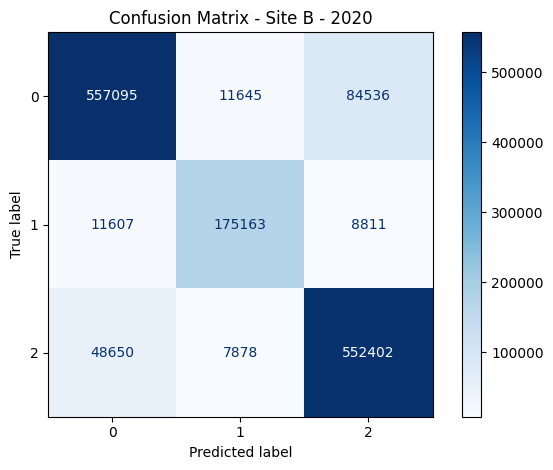


Training with 7000 samples...


Training Epoch 1: 100%|██████████| 110/110 [00:02<00:00, 42.06it/s]


Loss: 0.2577 + 1e-08 * 2868372.0


Validation: 100%|██████████| 1519/1519 [00:11<00:00, 135.34it/s]


Epoch [1/15] Train Loss: 0.5970, Train Acc: 0.8017 | Val Loss: 0.3685, Val Acc: 0.8664


Training Epoch 2: 100%|██████████| 110/110 [00:02<00:00, 41.95it/s]


Loss: 0.1277 + 1e-08 * 2860020.75


Validation: 100%|██████████| 1519/1519 [00:11<00:00, 135.32it/s]


Epoch [2/15] Train Loss: 0.3473, Train Acc: 0.8779 | Val Loss: 0.3379, Val Acc: 0.8772


Training Epoch 3: 100%|██████████| 110/110 [00:02<00:00, 42.04it/s]


Loss: 0.0978 + 1e-08 * 2851027.75


Validation: 100%|██████████| 1519/1519 [00:11<00:00, 131.37it/s]


Epoch [3/15] Train Loss: 0.3104, Train Acc: 0.8874 | Val Loss: 0.3238, Val Acc: 0.8835


Training Epoch 4: 100%|██████████| 110/110 [00:02<00:00, 40.89it/s]


Loss: 0.0715 + 1e-08 * 2843667.0


Validation: 100%|██████████| 1519/1519 [00:11<00:00, 128.86it/s]


Epoch [4/15] Train Loss: 0.2864, Train Acc: 0.8997 | Val Loss: 0.3126, Val Acc: 0.8855


Training Epoch 5: 100%|██████████| 110/110 [00:02<00:00, 41.12it/s]


Loss: 0.2973 + 1e-08 * 2836100.5


Validation: 100%|██████████| 1519/1519 [00:11<00:00, 129.84it/s]


Epoch [5/15] Train Loss: 0.2636, Train Acc: 0.9089 | Val Loss: 0.3211, Val Acc: 0.8813


Training Epoch 6: 100%|██████████| 110/110 [00:02<00:00, 40.78it/s]


Loss: 0.4190 + 1e-08 * 2831141.25


Validation: 100%|██████████| 1519/1519 [00:11<00:00, 130.24it/s]


Epoch [6/15] Train Loss: 0.2555, Train Acc: 0.9131 | Val Loss: 0.3081, Val Acc: 0.8915


Training Epoch 7: 100%|██████████| 110/110 [00:02<00:00, 41.97it/s]


Loss: 0.2587 + 1e-08 * 2827314.5


Validation: 100%|██████████| 1519/1519 [00:11<00:00, 135.43it/s]


Epoch [7/15] Train Loss: 0.2361, Train Acc: 0.9177 | Val Loss: 0.3214, Val Acc: 0.8894


Training Epoch 8: 100%|██████████| 110/110 [00:02<00:00, 41.19it/s]


Loss: 0.2365 + 1e-08 * 2824365.5


Validation: 100%|██████████| 1519/1519 [00:11<00:00, 128.89it/s]


Epoch [8/15] Train Loss: 0.2294, Train Acc: 0.9230 | Val Loss: 0.3162, Val Acc: 0.8878


Training Epoch 9: 100%|██████████| 110/110 [00:02<00:00, 40.98it/s]


Loss: 0.2836 + 1e-08 * 2822393.25


Validation: 100%|██████████| 1519/1519 [00:11<00:00, 131.54it/s]


Epoch [9/15] Train Loss: 0.2080, Train Acc: 0.9314 | Val Loss: 0.3139, Val Acc: 0.8913


Training Epoch 10: 100%|██████████| 110/110 [00:02<00:00, 41.89it/s]


Loss: 0.0984 + 1e-08 * 2825319.5


Validation: 100%|██████████| 1519/1519 [00:11<00:00, 136.10it/s]


Epoch [10/15] Train Loss: 0.1970, Train Acc: 0.9347 | Val Loss: 0.3346, Val Acc: 0.8880


Training Epoch 11: 100%|██████████| 110/110 [00:02<00:00, 42.27it/s]


Loss: 0.1994 + 1e-08 * 2825129.75


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 139.03it/s]


Epoch [11/15] Train Loss: 0.1811, Train Acc: 0.9403 | Val Loss: 0.3407, Val Acc: 0.8897


Training Epoch 12: 100%|██████████| 110/110 [00:02<00:00, 42.56it/s]


Loss: 0.5583 + 1e-08 * 2829837.5


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 138.49it/s]


Epoch [12/15] Train Loss: 0.1740, Train Acc: 0.9447 | Val Loss: 0.3477, Val Acc: 0.8862


Training Epoch 13: 100%|██████████| 110/110 [00:02<00:00, 42.59it/s]


Loss: 0.4669 + 1e-08 * 2836231.25


Validation: 100%|██████████| 1519/1519 [00:11<00:00, 137.15it/s]


Epoch [13/15] Train Loss: 0.1585, Train Acc: 0.9499 | Val Loss: 0.3545, Val Acc: 0.8864


Training Epoch 14: 100%|██████████| 110/110 [00:02<00:00, 42.23it/s]


Loss: 0.1265 + 1e-08 * 2839448.0


Validation: 100%|██████████| 1519/1519 [00:11<00:00, 136.26it/s]


Epoch [14/15] Train Loss: 0.1506, Train Acc: 0.9563 | Val Loss: 0.3648, Val Acc: 0.8847


Training Epoch 15: 100%|██████████| 110/110 [00:02<00:00, 41.69it/s]


Loss: 0.1730 + 1e-08 * 2845376.75


Validation: 100%|██████████| 1519/1519 [00:11<00:00, 137.50it/s]


Epoch [15/15] Train Loss: 0.1393, Train Acc: 0.9574 | Val Loss: 0.3709, Val Acc: 0.8857


Stochastic Validation (T=15): 100%|██████████| 22778/22778 [02:47<00:00, 135.87it/s]


Stochastic Accuracy (mean over T): 0.8852
Cohen's Kappa: 0.8105
Per-class F1: [0.88262511 0.89813271 0.88388167]
Average F1 (macro): 0.8882


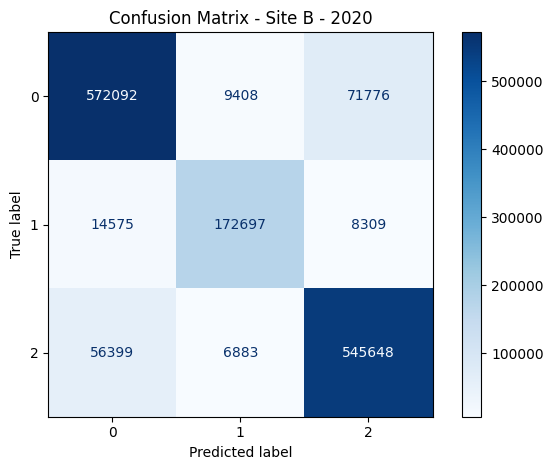


Training with 8000 samples...


Training Epoch 1: 100%|██████████| 125/125 [00:02<00:00, 43.22it/s]


Loss: 0.3085 + 1e-08 * 2867990.75


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 142.18it/s]


Epoch [1/15] Train Loss: 0.5656, Train Acc: 0.8101 | Val Loss: 0.3614, Val Acc: 0.8687


Training Epoch 2: 100%|██████████| 125/125 [00:02<00:00, 43.00it/s]


Loss: 0.3204 + 1e-08 * 2857437.75


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 142.44it/s]


Epoch [2/15] Train Loss: 0.3320, Train Acc: 0.8815 | Val Loss: 0.3301, Val Acc: 0.8808


Training Epoch 3: 100%|██████████| 125/125 [00:02<00:00, 43.30it/s]


Loss: 0.2684 + 1e-08 * 2847724.5


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 142.31it/s]


Epoch [3/15] Train Loss: 0.3026, Train Acc: 0.8949 | Val Loss: 0.3168, Val Acc: 0.8872


Training Epoch 4: 100%|██████████| 125/125 [00:02<00:00, 43.43it/s]


Loss: 0.2573 + 1e-08 * 2838146.0


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 142.32it/s]


Epoch [4/15] Train Loss: 0.2813, Train Acc: 0.9042 | Val Loss: 0.3087, Val Acc: 0.8905


Training Epoch 5: 100%|██████████| 125/125 [00:02<00:00, 42.90it/s]


Loss: 0.2973 + 1e-08 * 2829522.75


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 141.66it/s]


Epoch [5/15] Train Loss: 0.2637, Train Acc: 0.9073 | Val Loss: 0.3064, Val Acc: 0.8913


Training Epoch 6: 100%|██████████| 125/125 [00:02<00:00, 43.33it/s]


Loss: 0.3991 + 1e-08 * 2822657.5


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 140.91it/s]


Epoch [6/15] Train Loss: 0.2502, Train Acc: 0.9144 | Val Loss: 0.3270, Val Acc: 0.8834


Training Epoch 7: 100%|██████████| 125/125 [00:02<00:00, 42.99it/s]


Loss: 0.1837 + 1e-08 * 2817165.0


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 139.86it/s]


Epoch [7/15] Train Loss: 0.2351, Train Acc: 0.9204 | Val Loss: 0.3039, Val Acc: 0.8939


Training Epoch 8: 100%|██████████| 125/125 [00:02<00:00, 43.03it/s]


Loss: 0.1814 + 1e-08 * 2813042.25


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 140.62it/s]


Epoch [8/15] Train Loss: 0.2190, Train Acc: 0.9280 | Val Loss: 0.3081, Val Acc: 0.8928


Training Epoch 9: 100%|██████████| 125/125 [00:02<00:00, 43.06it/s]


Loss: 0.2726 + 1e-08 * 2812345.25


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 141.02it/s]


Epoch [9/15] Train Loss: 0.2098, Train Acc: 0.9285 | Val Loss: 0.3157, Val Acc: 0.8919


Training Epoch 10: 100%|██████████| 125/125 [00:02<00:00, 42.69it/s]


Loss: 0.2920 + 1e-08 * 2812677.0


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 140.96it/s]


Epoch [10/15] Train Loss: 0.1979, Train Acc: 0.9349 | Val Loss: 0.3342, Val Acc: 0.8902


Training Epoch 11: 100%|██████████| 125/125 [00:02<00:00, 42.86it/s]


Loss: 0.1590 + 1e-08 * 2815330.5


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 140.83it/s]


Epoch [11/15] Train Loss: 0.1844, Train Acc: 0.9397 | Val Loss: 0.3337, Val Acc: 0.8910


Training Epoch 12: 100%|██████████| 125/125 [00:02<00:00, 43.02it/s]


Loss: 0.1639 + 1e-08 * 2818056.0


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 141.28it/s]


Epoch [12/15] Train Loss: 0.1737, Train Acc: 0.9451 | Val Loss: 0.3466, Val Acc: 0.8880


Training Epoch 13: 100%|██████████| 125/125 [00:02<00:00, 42.75it/s]


Loss: 0.0713 + 1e-08 * 2823940.75


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 140.48it/s]


Epoch [13/15] Train Loss: 0.1583, Train Acc: 0.9477 | Val Loss: 0.3466, Val Acc: 0.8885


Training Epoch 14: 100%|██████████| 125/125 [00:02<00:00, 42.86it/s]


Loss: 0.1127 + 1e-08 * 2829465.25


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 140.79it/s]


Epoch [14/15] Train Loss: 0.1491, Train Acc: 0.9533 | Val Loss: 0.3619, Val Acc: 0.8850


Training Epoch 15: 100%|██████████| 125/125 [00:02<00:00, 43.03it/s]


Loss: 0.1772 + 1e-08 * 2835021.0


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 141.00it/s]


Epoch [15/15] Train Loss: 0.1395, Train Acc: 0.9575 | Val Loss: 0.3617, Val Acc: 0.8889


Stochastic Validation (T=15): 100%|██████████| 22778/22778 [02:43<00:00, 139.37it/s]


Stochastic Accuracy (mean over T): 0.8880
Cohen's Kappa: 0.8157
Per-class F1: [0.88767109 0.89915385 0.88474856]
Average F1 (macro): 0.8905


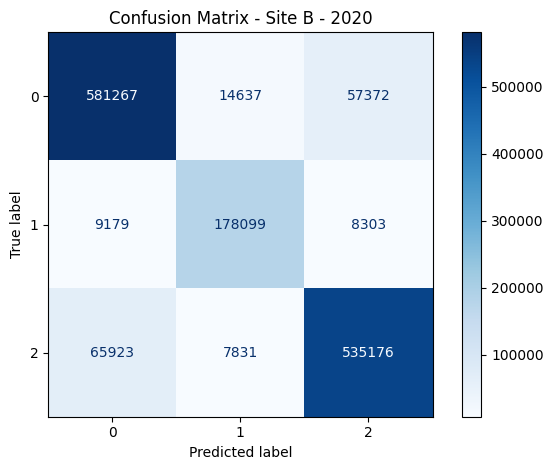


Training with 9000 samples...


Training Epoch 1: 100%|██████████| 141/141 [00:03<00:00, 42.81it/s]


Loss: 0.3593 + 1e-08 * 2866673.0


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 141.25it/s]


Epoch [1/15] Train Loss: 0.5489, Train Acc: 0.8163 | Val Loss: 0.3581, Val Acc: 0.8688


Training Epoch 2: 100%|██████████| 141/141 [00:03<00:00, 43.08it/s]


Loss: 0.3285 + 1e-08 * 2854172.0


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 140.67it/s]


Epoch [2/15] Train Loss: 0.3335, Train Acc: 0.8823 | Val Loss: 0.3253, Val Acc: 0.8822


Training Epoch 3: 100%|██████████| 141/141 [00:03<00:00, 43.14it/s]


Loss: 0.2109 + 1e-08 * 2841701.25


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 141.50it/s]


Epoch [3/15] Train Loss: 0.3029, Train Acc: 0.8943 | Val Loss: 0.3085, Val Acc: 0.8884


Training Epoch 4: 100%|██████████| 141/141 [00:03<00:00, 43.15it/s]


Loss: 0.2110 + 1e-08 * 2830412.0


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 141.36it/s]


Epoch [4/15] Train Loss: 0.2881, Train Acc: 0.9007 | Val Loss: 0.3057, Val Acc: 0.8910


Training Epoch 5: 100%|██████████| 141/141 [00:03<00:00, 42.80it/s]


Loss: 0.2404 + 1e-08 * 2821868.0


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 141.02it/s]


Epoch [5/15] Train Loss: 0.2674, Train Acc: 0.9104 | Val Loss: 0.3034, Val Acc: 0.8920


Training Epoch 6: 100%|██████████| 141/141 [00:03<00:00, 42.75it/s]


Loss: 0.1636 + 1e-08 * 2813522.25


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 141.28it/s]


Epoch [6/15] Train Loss: 0.2492, Train Acc: 0.9122 | Val Loss: 0.3147, Val Acc: 0.8877


Training Epoch 7: 100%|██████████| 141/141 [00:03<00:00, 42.99it/s]


Loss: 0.0805 + 1e-08 * 2809033.0


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 141.14it/s]


Epoch [7/15] Train Loss: 0.2413, Train Acc: 0.9186 | Val Loss: 0.3006, Val Acc: 0.8929


Training Epoch 8: 100%|██████████| 141/141 [00:03<00:00, 43.17it/s]


Loss: 0.2190 + 1e-08 * 2804201.5


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 141.06it/s]


Epoch [8/15] Train Loss: 0.2278, Train Acc: 0.9226 | Val Loss: 0.3044, Val Acc: 0.8954


Training Epoch 9: 100%|██████████| 141/141 [00:03<00:00, 42.66it/s]


Loss: 0.1873 + 1e-08 * 2804511.25


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 140.95it/s]


Epoch [9/15] Train Loss: 0.2160, Train Acc: 0.9294 | Val Loss: 0.3164, Val Acc: 0.8899


Training Epoch 10: 100%|██████████| 141/141 [00:03<00:00, 43.11it/s]


Loss: 0.1550 + 1e-08 * 2803199.25


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 141.12it/s]


Epoch [10/15] Train Loss: 0.2015, Train Acc: 0.9343 | Val Loss: 0.3184, Val Acc: 0.8895


Training Epoch 11: 100%|██████████| 141/141 [00:03<00:00, 42.68it/s]


Loss: 0.1802 + 1e-08 * 2805330.0


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 138.35it/s]


Epoch [11/15] Train Loss: 0.1880, Train Acc: 0.9384 | Val Loss: 0.3237, Val Acc: 0.8931


Training Epoch 12: 100%|██████████| 141/141 [00:03<00:00, 42.41it/s]


Loss: 0.0439 + 1e-08 * 2809830.0


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 139.67it/s]


Epoch [12/15] Train Loss: 0.1716, Train Acc: 0.9481 | Val Loss: 0.3430, Val Acc: 0.8886


Training Epoch 13: 100%|██████████| 141/141 [00:03<00:00, 42.23it/s]


Loss: 0.2275 + 1e-08 * 2814574.25


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 140.10it/s]


Epoch [13/15] Train Loss: 0.1670, Train Acc: 0.9492 | Val Loss: 0.3433, Val Acc: 0.8882


Training Epoch 14: 100%|██████████| 141/141 [00:03<00:00, 40.83it/s]


Loss: 0.0806 + 1e-08 * 2821020.75


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 141.39it/s]


Epoch [14/15] Train Loss: 0.1529, Train Acc: 0.9528 | Val Loss: 0.3439, Val Acc: 0.8918


Training Epoch 15: 100%|██████████| 141/141 [00:03<00:00, 43.19it/s]


Loss: 0.0777 + 1e-08 * 2826919.75


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 142.09it/s]


Epoch [15/15] Train Loss: 0.1437, Train Acc: 0.9551 | Val Loss: 0.3523, Val Acc: 0.8907


Stochastic Validation (T=15): 100%|██████████| 22778/22778 [02:44<00:00, 138.82it/s]


Stochastic Accuracy (mean over T): 0.8906
Cohen's Kappa: 0.8194
Per-class F1: [0.88967021 0.90764276 0.88629862]
Average F1 (macro): 0.8945


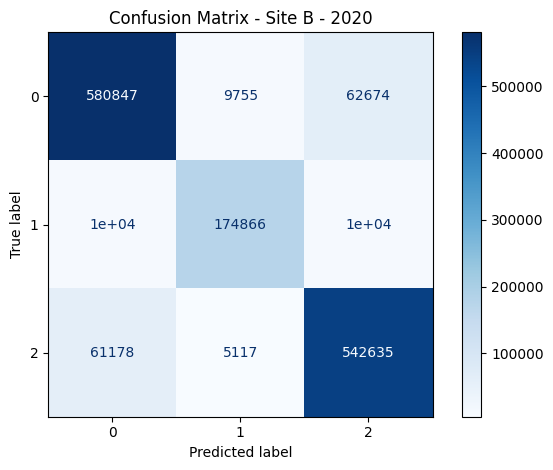


Training with 10000 samples...


Training Epoch 1: 100%|██████████| 157/157 [00:03<00:00, 43.10it/s]


Loss: 0.3064 + 1e-08 * 2866305.0


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 140.83it/s]


Epoch [1/15] Train Loss: 0.5186, Train Acc: 0.8229 | Val Loss: 0.3450, Val Acc: 0.8741


Training Epoch 2: 100%|██████████| 157/157 [00:03<00:00, 43.07it/s]


Loss: 0.2188 + 1e-08 * 2851230.0


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 142.18it/s]


Epoch [2/15] Train Loss: 0.3213, Train Acc: 0.8841 | Val Loss: 0.3231, Val Acc: 0.8816


Training Epoch 3: 100%|██████████| 157/157 [00:03<00:00, 43.08it/s]


Loss: 0.4604 + 1e-08 * 2837833.5


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 140.72it/s]


Epoch [3/15] Train Loss: 0.2967, Train Acc: 0.8952 | Val Loss: 0.3085, Val Acc: 0.8899


Training Epoch 4: 100%|██████████| 157/157 [00:03<00:00, 42.94it/s]


Loss: 0.1739 + 1e-08 * 2826477.5


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 140.50it/s]


Epoch [4/15] Train Loss: 0.2749, Train Acc: 0.9044 | Val Loss: 0.3042, Val Acc: 0.8925


Training Epoch 5: 100%|██████████| 157/157 [00:03<00:00, 43.32it/s]


Loss: 0.3251 + 1e-08 * 2814797.5


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 141.33it/s]


Epoch [5/15] Train Loss: 0.2630, Train Acc: 0.9104 | Val Loss: 0.3050, Val Acc: 0.8918


Training Epoch 6: 100%|██████████| 157/157 [00:03<00:00, 43.12it/s]


Loss: 0.1260 + 1e-08 * 2807202.75


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 141.73it/s]


Epoch [6/15] Train Loss: 0.2482, Train Acc: 0.9141 | Val Loss: 0.2983, Val Acc: 0.8964


Training Epoch 7: 100%|██████████| 157/157 [00:03<00:00, 43.22it/s]


Loss: 0.1250 + 1e-08 * 2800578.0


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 141.81it/s]


Epoch [7/15] Train Loss: 0.2320, Train Acc: 0.9202 | Val Loss: 0.3020, Val Acc: 0.8944


Training Epoch 8: 100%|██████████| 157/157 [00:03<00:00, 43.15it/s]


Loss: 0.2357 + 1e-08 * 2798740.25


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 141.68it/s]


Epoch [8/15] Train Loss: 0.2269, Train Acc: 0.9237 | Val Loss: 0.3056, Val Acc: 0.8958


Training Epoch 9: 100%|██████████| 157/157 [00:03<00:00, 43.31it/s]


Loss: 0.3005 + 1e-08 * 2796770.25


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 141.08it/s]


Epoch [9/15] Train Loss: 0.2116, Train Acc: 0.9313 | Val Loss: 0.3143, Val Acc: 0.8937


Training Epoch 10: 100%|██████████| 157/157 [00:03<00:00, 44.17it/s]


Loss: 0.1538 + 1e-08 * 2798543.0


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 143.39it/s]


Epoch [10/15] Train Loss: 0.2029, Train Acc: 0.9315 | Val Loss: 0.3134, Val Acc: 0.8940


Training Epoch 11: 100%|██████████| 157/157 [00:03<00:00, 43.59it/s]


Loss: 0.1473 + 1e-08 * 2801957.0


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 143.19it/s]


Epoch [11/15] Train Loss: 0.1880, Train Acc: 0.9383 | Val Loss: 0.3252, Val Acc: 0.8917


Training Epoch 12: 100%|██████████| 157/157 [00:03<00:00, 43.51it/s]


Loss: 0.2988 + 1e-08 * 2805622.75


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 143.22it/s]


Epoch [12/15] Train Loss: 0.1763, Train Acc: 0.9414 | Val Loss: 0.3262, Val Acc: 0.8937


Training Epoch 13: 100%|██████████| 157/157 [00:03<00:00, 43.67it/s]


Loss: 0.0347 + 1e-08 * 2810743.5


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 143.36it/s]


Epoch [13/15] Train Loss: 0.1707, Train Acc: 0.9456 | Val Loss: 0.3366, Val Acc: 0.8934


Training Epoch 14: 100%|██████████| 157/157 [00:03<00:00, 43.74it/s]


Loss: 0.1201 + 1e-08 * 2815604.25


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 143.42it/s]


Epoch [14/15] Train Loss: 0.1542, Train Acc: 0.9513 | Val Loss: 0.3487, Val Acc: 0.8910


Training Epoch 15: 100%|██████████| 157/157 [00:03<00:00, 43.70it/s]


Loss: 0.0604 + 1e-08 * 2824400.5


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 142.66it/s]


Epoch [15/15] Train Loss: 0.1530, Train Acc: 0.9525 | Val Loss: 0.3696, Val Acc: 0.8856


Stochastic Validation (T=15): 100%|██████████| 22778/22778 [02:44<00:00, 138.57it/s]


Stochastic Accuracy (mean over T): 0.8852
Cohen's Kappa: 0.8113
Per-class F1: [0.87999372 0.90119296 0.88523469]
Average F1 (macro): 0.8888


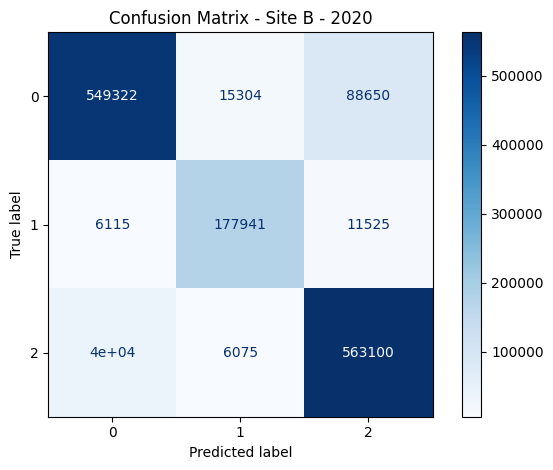


Training with 11000 samples...


Training Epoch 1: 100%|██████████| 172/172 [00:03<00:00, 43.02it/s]


Loss: 0.3091 + 1e-08 * 2865621.75


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 141.88it/s]


Epoch [1/15] Train Loss: 0.5157, Train Acc: 0.8281 | Val Loss: 0.3440, Val Acc: 0.8753


Training Epoch 2: 100%|██████████| 172/172 [00:03<00:00, 43.27it/s]


Loss: 0.3382 + 1e-08 * 2850217.75


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 143.00it/s]


Epoch [2/15] Train Loss: 0.3197, Train Acc: 0.8886 | Val Loss: 0.3244, Val Acc: 0.8834


Training Epoch 3: 100%|██████████| 172/172 [00:03<00:00, 43.83it/s]


Loss: 0.2230 + 1e-08 * 2834995.0


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 143.35it/s]


Epoch [3/15] Train Loss: 0.2897, Train Acc: 0.9009 | Val Loss: 0.3082, Val Acc: 0.8906


Training Epoch 4: 100%|██████████| 172/172 [00:03<00:00, 43.80it/s]


Loss: 0.2239 + 1e-08 * 2818840.75


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 143.06it/s]


Epoch [4/15] Train Loss: 0.2722, Train Acc: 0.9072 | Val Loss: 0.3006, Val Acc: 0.8928


Training Epoch 5: 100%|██████████| 172/172 [00:03<00:00, 43.70it/s]


Loss: 0.2029 + 1e-08 * 2806945.25


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 143.69it/s]


Epoch [5/15] Train Loss: 0.2553, Train Acc: 0.9117 | Val Loss: 0.2978, Val Acc: 0.8946


Training Epoch 6: 100%|██████████| 172/172 [00:03<00:00, 43.80it/s]


Loss: 0.2208 + 1e-08 * 2796016.75


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 143.59it/s]


Epoch [6/15] Train Loss: 0.2418, Train Acc: 0.9215 | Val Loss: 0.3111, Val Acc: 0.8899


Training Epoch 7: 100%|██████████| 172/172 [00:03<00:00, 43.64it/s]


Loss: 0.1720 + 1e-08 * 2787588.5


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 143.00it/s]


Epoch [7/15] Train Loss: 0.2331, Train Acc: 0.9212 | Val Loss: 0.3010, Val Acc: 0.8935


Training Epoch 8: 100%|██████████| 172/172 [00:03<00:00, 43.77it/s]


Loss: 0.1613 + 1e-08 * 2783726.5


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 143.39it/s]


Epoch [8/15] Train Loss: 0.2202, Train Acc: 0.9276 | Val Loss: 0.3071, Val Acc: 0.8910


Training Epoch 9: 100%|██████████| 172/172 [00:03<00:00, 43.45it/s]


Loss: 0.0566 + 1e-08 * 2777493.75


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 142.26it/s]


Epoch [9/15] Train Loss: 0.2070, Train Acc: 0.9314 | Val Loss: 0.3068, Val Acc: 0.8949


Training Epoch 10: 100%|██████████| 172/172 [00:03<00:00, 43.54it/s]


Loss: 0.2572 + 1e-08 * 2777574.0


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 142.66it/s]


Epoch [10/15] Train Loss: 0.1943, Train Acc: 0.9368 | Val Loss: 0.3199, Val Acc: 0.8916


Training Epoch 11: 100%|██████████| 172/172 [00:03<00:00, 43.56it/s]


Loss: 0.1476 + 1e-08 * 2780686.25


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 142.50it/s]


Epoch [11/15] Train Loss: 0.1872, Train Acc: 0.9385 | Val Loss: 0.3289, Val Acc: 0.8924


Training Epoch 12: 100%|██████████| 172/172 [00:03<00:00, 43.47it/s]


Loss: 0.1501 + 1e-08 * 2784218.5


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 141.80it/s]


Epoch [12/15] Train Loss: 0.1756, Train Acc: 0.9440 | Val Loss: 0.3179, Val Acc: 0.8958


Training Epoch 13: 100%|██████████| 172/172 [00:03<00:00, 43.20it/s]


Loss: 0.0391 + 1e-08 * 2789609.75


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 141.79it/s]


Epoch [13/15] Train Loss: 0.1627, Train Acc: 0.9475 | Val Loss: 0.3279, Val Acc: 0.8935


Training Epoch 14: 100%|██████████| 172/172 [00:03<00:00, 43.18it/s]


Loss: 0.1318 + 1e-08 * 2797610.0


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 142.11it/s]


Epoch [14/15] Train Loss: 0.1564, Train Acc: 0.9492 | Val Loss: 0.3368, Val Acc: 0.8894


Training Epoch 15: 100%|██████████| 172/172 [00:03<00:00, 43.34it/s]


Loss: 0.1782 + 1e-08 * 2802853.75


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 142.32it/s]


Epoch [15/15] Train Loss: 0.1451, Train Acc: 0.9558 | Val Loss: 0.3596, Val Acc: 0.8856


Stochastic Validation (T=15): 100%|██████████| 22778/22778 [02:42<00:00, 139.77it/s]


Stochastic Accuracy (mean over T): 0.8858
Cohen's Kappa: 0.8115
Per-class F1: [0.8846585  0.90206116 0.88182433]
Average F1 (macro): 0.8895


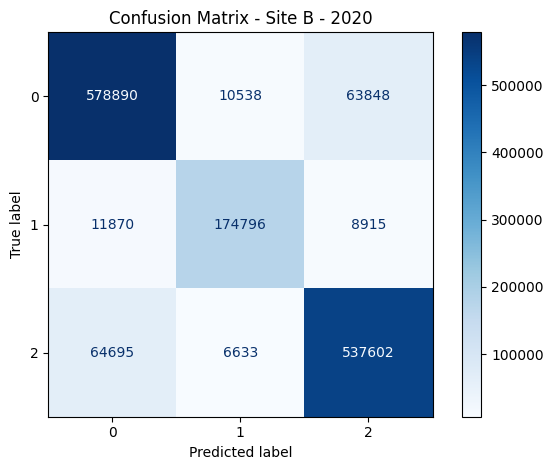


Training with 12000 samples...


Training Epoch 1: 100%|██████████| 188/188 [00:04<00:00, 43.64it/s]


Loss: 0.4708 + 1e-08 * 2863813.5


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 143.01it/s]


Epoch [1/15] Train Loss: 0.4926, Train Acc: 0.8319 | Val Loss: 0.3450, Val Acc: 0.8739


Training Epoch 2: 100%|██████████| 188/188 [00:04<00:00, 43.76it/s]


Loss: 0.6047 + 1e-08 * 2847797.75


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 143.17it/s]


Epoch [2/15] Train Loss: 0.3158, Train Acc: 0.8901 | Val Loss: 0.3128, Val Acc: 0.8877


Training Epoch 3: 100%|██████████| 188/188 [00:04<00:00, 43.90it/s]


Loss: 0.1548 + 1e-08 * 2829938.0


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 142.90it/s]


Epoch [3/15] Train Loss: 0.2863, Train Acc: 0.9008 | Val Loss: 0.3034, Val Acc: 0.8925


Training Epoch 4: 100%|██████████| 188/188 [00:04<00:00, 43.10it/s]


Loss: 0.2806 + 1e-08 * 2812385.5


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 142.00it/s]


Epoch [4/15] Train Loss: 0.2711, Train Acc: 0.9057 | Val Loss: 0.2958, Val Acc: 0.8958


Training Epoch 5: 100%|██████████| 188/188 [00:04<00:00, 43.26it/s]


Loss: 0.1537 + 1e-08 * 2797886.0


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 141.93it/s]


Epoch [5/15] Train Loss: 0.2555, Train Acc: 0.9123 | Val Loss: 0.2996, Val Acc: 0.8948


Training Epoch 6: 100%|██████████| 188/188 [00:04<00:00, 43.07it/s]


Loss: 0.1238 + 1e-08 * 2785397.5


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 142.32it/s]


Epoch [6/15] Train Loss: 0.2435, Train Acc: 0.9149 | Val Loss: 0.3258, Val Acc: 0.8827


Training Epoch 7: 100%|██████████| 188/188 [00:04<00:00, 43.38it/s]


Loss: 0.1760 + 1e-08 * 2775916.5


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 142.32it/s]


Epoch [7/15] Train Loss: 0.2312, Train Acc: 0.9227 | Val Loss: 0.2971, Val Acc: 0.8964


Training Epoch 8: 100%|██████████| 188/188 [00:04<00:00, 43.25it/s]


Loss: 0.2577 + 1e-08 * 2770780.75


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 142.85it/s]


Epoch [8/15] Train Loss: 0.2215, Train Acc: 0.9247 | Val Loss: 0.3070, Val Acc: 0.8928


Training Epoch 9: 100%|██████████| 188/188 [00:04<00:00, 43.54it/s]


Loss: 0.2324 + 1e-08 * 2768129.0


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 142.57it/s]


Epoch [9/15] Train Loss: 0.2084, Train Acc: 0.9321 | Val Loss: 0.3084, Val Acc: 0.8960


Training Epoch 10: 100%|██████████| 188/188 [00:04<00:00, 43.46it/s]


Loss: 0.1113 + 1e-08 * 2766947.5


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 142.72it/s]


Epoch [10/15] Train Loss: 0.1981, Train Acc: 0.9353 | Val Loss: 0.3041, Val Acc: 0.8960


Training Epoch 11: 100%|██████████| 188/188 [00:04<00:00, 43.55it/s]


Loss: 0.0890 + 1e-08 * 2767584.25


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 142.62it/s]


Epoch [11/15] Train Loss: 0.1843, Train Acc: 0.9397 | Val Loss: 0.3137, Val Acc: 0.8959


Training Epoch 12: 100%|██████████| 188/188 [00:04<00:00, 43.40it/s]


Loss: 0.0841 + 1e-08 * 2772287.25


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 142.49it/s]


Epoch [12/15] Train Loss: 0.1729, Train Acc: 0.9433 | Val Loss: 0.3199, Val Acc: 0.8956


Training Epoch 13: 100%|██████████| 188/188 [00:04<00:00, 43.49it/s]


Loss: 0.0589 + 1e-08 * 2776326.5


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 142.37it/s]


Epoch [13/15] Train Loss: 0.1631, Train Acc: 0.9479 | Val Loss: 0.3401, Val Acc: 0.8894


Training Epoch 14: 100%|██████████| 188/188 [00:04<00:00, 43.41it/s]


Loss: 0.2102 + 1e-08 * 2784530.75


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 142.34it/s]


Epoch [14/15] Train Loss: 0.1575, Train Acc: 0.9507 | Val Loss: 0.3402, Val Acc: 0.8919


Training Epoch 15: 100%|██████████| 188/188 [00:04<00:00, 43.63it/s]


Loss: 0.1691 + 1e-08 * 2792817.5


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 142.63it/s]


Epoch [15/15] Train Loss: 0.1493, Train Acc: 0.9543 | Val Loss: 0.3528, Val Acc: 0.8915


Stochastic Validation (T=15): 100%|██████████| 22778/22778 [02:41<00:00, 140.90it/s]


Stochastic Accuracy (mean over T): 0.8903
Cohen's Kappa: 0.8194
Per-class F1: [0.88898283 0.90492061 0.88714539]
Average F1 (macro): 0.8937


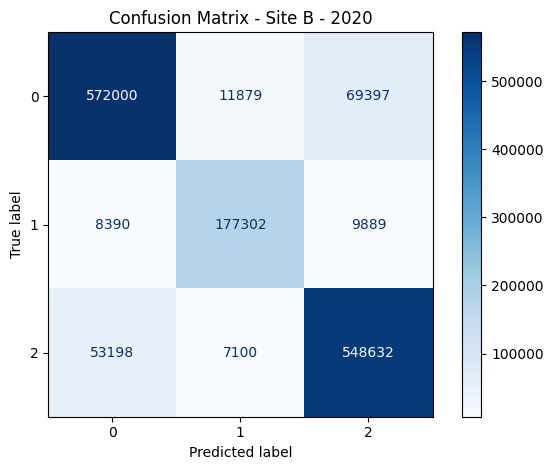


Training with 13000 samples...


Training Epoch 1: 100%|██████████| 204/204 [00:04<00:00, 43.58it/s]


Loss: 0.0670 + 1e-08 * 2862012.75


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 142.62it/s]


Epoch [1/15] Train Loss: 0.4728, Train Acc: 0.8361 | Val Loss: 0.3364, Val Acc: 0.8765


Training Epoch 2: 100%|██████████| 204/204 [00:04<00:00, 43.40it/s]


Loss: 0.3129 + 1e-08 * 2842378.75


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 141.63it/s]


Epoch [2/15] Train Loss: 0.3094, Train Acc: 0.8905 | Val Loss: 0.3131, Val Acc: 0.8874


Training Epoch 3: 100%|██████████| 204/204 [00:04<00:00, 43.24it/s]


Loss: 0.3776 + 1e-08 * 2821709.0


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 142.37it/s]


Epoch [3/15] Train Loss: 0.2849, Train Acc: 0.8999 | Val Loss: 0.3072, Val Acc: 0.8889


Training Epoch 4: 100%|██████████| 204/204 [00:04<00:00, 43.32it/s]


Loss: 0.0930 + 1e-08 * 2805209.25


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 142.64it/s]


Epoch [4/15] Train Loss: 0.2697, Train Acc: 0.9063 | Val Loss: 0.2945, Val Acc: 0.8980


Training Epoch 5: 100%|██████████| 204/204 [00:04<00:00, 43.54it/s]


Loss: 0.4609 + 1e-08 * 2787743.0


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 142.49it/s]


Epoch [5/15] Train Loss: 0.2564, Train Acc: 0.9122 | Val Loss: 0.3072, Val Acc: 0.8886


Training Epoch 6: 100%|██████████| 204/204 [00:04<00:00, 43.31it/s]


Loss: 0.1142 + 1e-08 * 2776575.25


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 142.61it/s]


Epoch [6/15] Train Loss: 0.2465, Train Acc: 0.9160 | Val Loss: 0.3003, Val Acc: 0.8942


Training Epoch 7: 100%|██████████| 204/204 [00:04<00:00, 43.57it/s]


Loss: 0.2353 + 1e-08 * 2762898.5


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 142.74it/s]


Epoch [7/15] Train Loss: 0.2326, Train Acc: 0.9192 | Val Loss: 0.2958, Val Acc: 0.8974


Training Epoch 8: 100%|██████████| 204/204 [00:04<00:00, 43.55it/s]


Loss: 0.3153 + 1e-08 * 2755903.5


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 142.62it/s]


Epoch [8/15] Train Loss: 0.2232, Train Acc: 0.9234 | Val Loss: 0.2930, Val Acc: 0.8986


Training Epoch 9: 100%|██████████| 204/204 [00:04<00:00, 43.62it/s]


Loss: 0.3578 + 1e-08 * 2753356.0


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 142.60it/s]


Epoch [9/15] Train Loss: 0.2122, Train Acc: 0.9285 | Val Loss: 0.3050, Val Acc: 0.8964


Training Epoch 10: 100%|██████████| 204/204 [00:04<00:00, 44.23it/s]


Loss: 0.3665 + 1e-08 * 2749769.75


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 143.07it/s]


Epoch [10/15] Train Loss: 0.1982, Train Acc: 0.9342 | Val Loss: 0.3101, Val Acc: 0.8929


Training Epoch 11: 100%|██████████| 204/204 [00:04<00:00, 44.06it/s]


Loss: 0.0272 + 1e-08 * 2751086.25


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 143.03it/s]


Epoch [11/15] Train Loss: 0.1904, Train Acc: 0.9363 | Val Loss: 0.3057, Val Acc: 0.8973


Training Epoch 12: 100%|██████████| 204/204 [00:04<00:00, 43.74it/s]


Loss: 0.4869 + 1e-08 * 2753881.75


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 143.38it/s]


Epoch [12/15] Train Loss: 0.1794, Train Acc: 0.9422 | Val Loss: 0.3234, Val Acc: 0.8933


Training Epoch 13: 100%|██████████| 204/204 [00:04<00:00, 43.82it/s]


Loss: 0.1728 + 1e-08 * 2760148.0


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 143.39it/s]


Epoch [13/15] Train Loss: 0.1696, Train Acc: 0.9441 | Val Loss: 0.3343, Val Acc: 0.8936


Training Epoch 14: 100%|██████████| 204/204 [00:04<00:00, 43.77it/s]


Loss: 0.1850 + 1e-08 * 2765841.0


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 143.72it/s]


Epoch [14/15] Train Loss: 0.1602, Train Acc: 0.9513 | Val Loss: 0.3289, Val Acc: 0.8927


Training Epoch 15: 100%|██████████| 204/204 [00:04<00:00, 44.00it/s]


Loss: 0.4451 + 1e-08 * 2773227.0


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 142.89it/s]


Epoch [15/15] Train Loss: 0.1530, Train Acc: 0.9535 | Val Loss: 0.3463, Val Acc: 0.8904


Stochastic Validation (T=15): 100%|██████████| 22778/22778 [02:42<00:00, 140.30it/s]


Stochastic Accuracy (mean over T): 0.8902
Cohen's Kappa: 0.8193
Per-class F1: [0.88893561 0.90097477 0.88806034]
Average F1 (macro): 0.8927


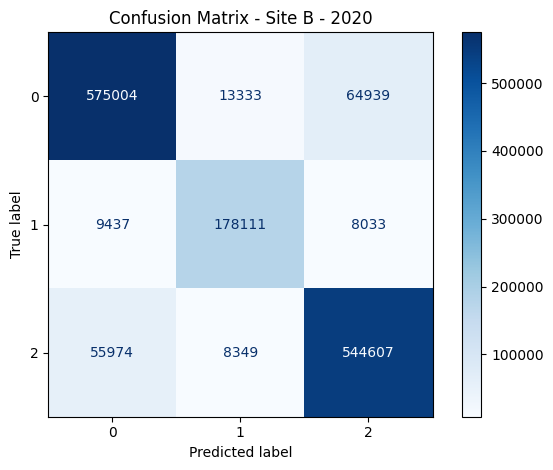


Training with 14000 samples...


Training Epoch 1: 100%|██████████| 219/219 [00:05<00:00, 43.46it/s]


Loss: 0.3340 + 1e-08 * 2860727.0


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 142.47it/s]


Epoch [1/15] Train Loss: 0.4665, Train Acc: 0.8381 | Val Loss: 0.3393, Val Acc: 0.8765


Training Epoch 2: 100%|██████████| 219/219 [00:05<00:00, 43.64it/s]


Loss: 0.1610 + 1e-08 * 2839368.25


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 142.37it/s]


Epoch [2/15] Train Loss: 0.3105, Train Acc: 0.8906 | Val Loss: 0.3074, Val Acc: 0.8894


Training Epoch 3: 100%|██████████| 219/219 [00:05<00:00, 43.63it/s]


Loss: 0.4165 + 1e-08 * 2816623.25


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 143.33it/s]


Epoch [3/15] Train Loss: 0.2816, Train Acc: 0.9029 | Val Loss: 0.3050, Val Acc: 0.8889


Training Epoch 4: 100%|██████████| 219/219 [00:04<00:00, 43.90it/s]


Loss: 0.2737 + 1e-08 * 2794503.5


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 143.20it/s]


Epoch [4/15] Train Loss: 0.2665, Train Acc: 0.9091 | Val Loss: 0.2933, Val Acc: 0.8940


Training Epoch 5: 100%|██████████| 219/219 [00:04<00:00, 43.89it/s]


Loss: 0.2077 + 1e-08 * 2776057.25


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 143.49it/s]


Epoch [5/15] Train Loss: 0.2534, Train Acc: 0.9127 | Val Loss: 0.2983, Val Acc: 0.8927


Training Epoch 6: 100%|██████████| 219/219 [00:04<00:00, 44.00it/s]


Loss: 0.2258 + 1e-08 * 2758650.0


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 143.48it/s]


Epoch [6/15] Train Loss: 0.2404, Train Acc: 0.9178 | Val Loss: 0.2918, Val Acc: 0.8957


Training Epoch 7: 100%|██████████| 219/219 [00:04<00:00, 43.95it/s]


Loss: 0.1517 + 1e-08 * 2749591.25


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 143.20it/s]


Epoch [7/15] Train Loss: 0.2328, Train Acc: 0.9194 | Val Loss: 0.3049, Val Acc: 0.8930


Training Epoch 8: 100%|██████████| 219/219 [00:04<00:00, 44.05it/s]


Loss: 0.1127 + 1e-08 * 2739909.5


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 142.95it/s]


Epoch [8/15] Train Loss: 0.2213, Train Acc: 0.9240 | Val Loss: 0.3028, Val Acc: 0.8936


Training Epoch 9: 100%|██████████| 219/219 [00:04<00:00, 43.85it/s]


Loss: 0.1840 + 1e-08 * 2734504.0


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 143.33it/s]


Epoch [9/15] Train Loss: 0.2117, Train Acc: 0.9276 | Val Loss: 0.3088, Val Acc: 0.8932


Training Epoch 10: 100%|██████████| 219/219 [00:04<00:00, 43.88it/s]


Loss: 0.1068 + 1e-08 * 2733970.5


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 142.21it/s]


Epoch [10/15] Train Loss: 0.1987, Train Acc: 0.9331 | Val Loss: 0.3088, Val Acc: 0.8926


Training Epoch 11: 100%|██████████| 219/219 [00:05<00:00, 43.49it/s]


Loss: 0.4073 + 1e-08 * 2737363.0


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 142.52it/s]


Epoch [11/15] Train Loss: 0.1910, Train Acc: 0.9378 | Val Loss: 0.3132, Val Acc: 0.8939


Training Epoch 12: 100%|██████████| 219/219 [00:05<00:00, 43.51it/s]


Loss: 0.2626 + 1e-08 * 2740329.5


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 142.63it/s]


Epoch [12/15] Train Loss: 0.1830, Train Acc: 0.9391 | Val Loss: 0.3183, Val Acc: 0.8947


Training Epoch 13: 100%|██████████| 219/219 [00:05<00:00, 43.55it/s]


Loss: 0.1102 + 1e-08 * 2744285.5


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 142.29it/s]


Epoch [13/15] Train Loss: 0.1717, Train Acc: 0.9444 | Val Loss: 0.3285, Val Acc: 0.8936


Training Epoch 14: 100%|██████████| 219/219 [00:05<00:00, 43.34it/s]


Loss: 0.0543 + 1e-08 * 2753119.0


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 142.39it/s]


Epoch [14/15] Train Loss: 0.1568, Train Acc: 0.9499 | Val Loss: 0.3423, Val Acc: 0.8933


Training Epoch 15: 100%|██████████| 219/219 [00:05<00:00, 43.58it/s]


Loss: 0.1440 + 1e-08 * 2759490.5


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 142.61it/s]


Epoch [15/15] Train Loss: 0.1518, Train Acc: 0.9517 | Val Loss: 0.3403, Val Acc: 0.8937


Stochastic Validation (T=15): 100%|██████████| 22778/22778 [02:42<00:00, 140.01it/s]


Stochastic Accuracy (mean over T): 0.8935
Cohen's Kappa: 0.8246
Per-class F1: [0.89197354 0.90552977 0.89136115]
Average F1 (macro): 0.8963


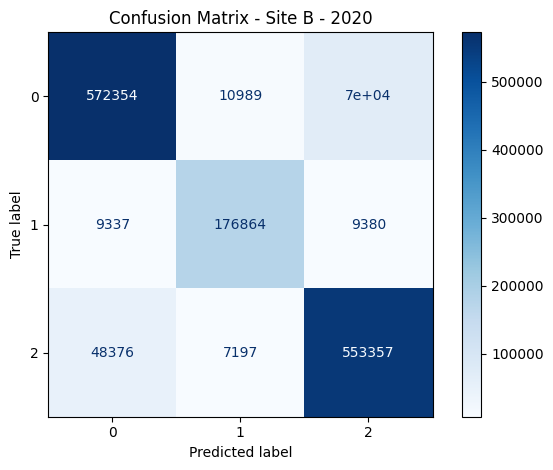


Training with 15000 samples...


Training Epoch 1: 100%|██████████| 235/235 [00:05<00:00, 43.23it/s]


Loss: 0.2336 + 1e-08 * 2857848.25


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 141.94it/s]


Epoch [1/15] Train Loss: 0.4515, Train Acc: 0.8444 | Val Loss: 0.3296, Val Acc: 0.8779


Training Epoch 2: 100%|██████████| 235/235 [00:05<00:00, 43.05it/s]


Loss: 0.3044 + 1e-08 * 2833890.25


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 141.78it/s]


Epoch [2/15] Train Loss: 0.3087, Train Acc: 0.8926 | Val Loss: 0.3070, Val Acc: 0.8905


Training Epoch 3: 100%|██████████| 235/235 [00:05<00:00, 42.76it/s]


Loss: 0.1132 + 1e-08 * 2808987.75


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 140.29it/s]


Epoch [3/15] Train Loss: 0.2822, Train Acc: 0.9015 | Val Loss: 0.2980, Val Acc: 0.8944


Training Epoch 4: 100%|██████████| 235/235 [00:05<00:00, 42.89it/s]


Loss: 0.2460 + 1e-08 * 2785314.0


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 140.68it/s]


Epoch [4/15] Train Loss: 0.2696, Train Acc: 0.9062 | Val Loss: 0.3017, Val Acc: 0.8927


Training Epoch 5: 100%|██████████| 235/235 [00:05<00:00, 42.76it/s]


Loss: 0.1013 + 1e-08 * 2767947.5


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 140.31it/s]


Epoch [5/15] Train Loss: 0.2569, Train Acc: 0.9105 | Val Loss: 0.2906, Val Acc: 0.8975


Training Epoch 6: 100%|██████████| 235/235 [00:05<00:00, 42.66it/s]


Loss: 0.5207 + 1e-08 * 2751134.0


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 140.96it/s]


Epoch [6/15] Train Loss: 0.2457, Train Acc: 0.9150 | Val Loss: 0.3364, Val Acc: 0.8750


Training Epoch 7: 100%|██████████| 235/235 [00:05<00:00, 42.74it/s]


Loss: 0.0881 + 1e-08 * 2741974.0


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 140.42it/s]


Epoch [7/15] Train Loss: 0.2331, Train Acc: 0.9217 | Val Loss: 0.2914, Val Acc: 0.8956


Training Epoch 8: 100%|██████████| 235/235 [00:05<00:00, 42.60it/s]


Loss: 0.1280 + 1e-08 * 2731428.5


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 140.95it/s]


Epoch [8/15] Train Loss: 0.2196, Train Acc: 0.9245 | Val Loss: 0.2958, Val Acc: 0.8972


Training Epoch 9: 100%|██████████| 235/235 [00:05<00:00, 42.89it/s]


Loss: 0.3705 + 1e-08 * 2726424.0


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 140.25it/s]


Epoch [9/15] Train Loss: 0.2122, Train Acc: 0.9258 | Val Loss: 0.3157, Val Acc: 0.8893


Training Epoch 10: 100%|██████████| 235/235 [00:05<00:00, 42.60it/s]


Loss: 0.3281 + 1e-08 * 2723676.0


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 140.36it/s]


Epoch [10/15] Train Loss: 0.2005, Train Acc: 0.9339 | Val Loss: 0.2968, Val Acc: 0.8988


Training Epoch 11: 100%|██████████| 235/235 [00:05<00:00, 42.65it/s]


Loss: 0.1661 + 1e-08 * 2724344.5


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 139.34it/s]


Epoch [11/15] Train Loss: 0.1898, Train Acc: 0.9363 | Val Loss: 0.3183, Val Acc: 0.8912


Training Epoch 12: 100%|██████████| 235/235 [00:05<00:00, 42.66it/s]


Loss: 0.1867 + 1e-08 * 2729497.5


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 140.42it/s]


Epoch [12/15] Train Loss: 0.1821, Train Acc: 0.9392 | Val Loss: 0.3150, Val Acc: 0.8932


Training Epoch 13: 100%|██████████| 235/235 [00:05<00:00, 42.59it/s]


Loss: 0.3102 + 1e-08 * 2734729.0


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 139.63it/s]


Epoch [13/15] Train Loss: 0.1717, Train Acc: 0.9449 | Val Loss: 0.3195, Val Acc: 0.8941


Training Epoch 14: 100%|██████████| 235/235 [00:05<00:00, 42.71it/s]


Loss: 0.5094 + 1e-08 * 2742400.25


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 140.18it/s]


Epoch [14/15] Train Loss: 0.1605, Train Acc: 0.9493 | Val Loss: 0.3232, Val Acc: 0.8959


Training Epoch 15: 100%|██████████| 235/235 [00:05<00:00, 42.80it/s]


Loss: 0.2119 + 1e-08 * 2753538.25


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 142.37it/s]


Epoch [15/15] Train Loss: 0.1539, Train Acc: 0.9513 | Val Loss: 0.3390, Val Acc: 0.8953


Stochastic Validation (T=15): 100%|██████████| 22778/22778 [02:47<00:00, 135.69it/s]


Stochastic Accuracy (mean over T): 0.8963
Cohen's Kappa: 0.8287
Per-class F1: [0.89529463 0.91230008 0.89246297]
Average F1 (macro): 0.9000


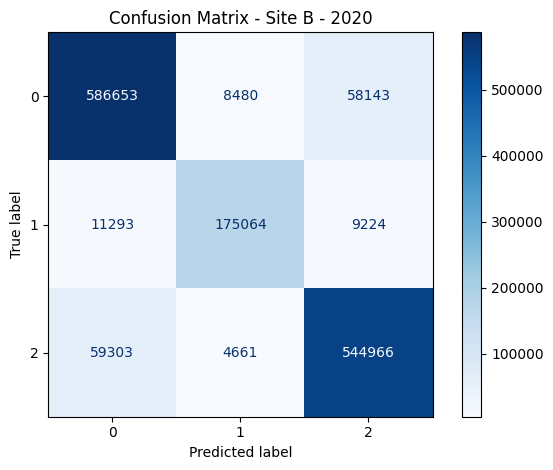

In [29]:
# Subsampled Training
if flag_subsampled:
    elbow_history = subsampled_training(X_train, y_train, val_dataloader, start=1000, end=15000, step=1000)
    
else: 
    # Simple training
    train_losses, val_losses, train_accs, val_accs = train(model, train_dataset, train_dataloader, val_dataloader, optimizer, KL_WEIGHT=KL_WEIGHT, EPOCHS=EPOCHS, T=T)

    acc, kappa, per_class_f1, avg_f1, cm = evaluate(model, test_dataloader, T, device=DEVICE)
    
    # Printing and plotting
    print("Stochastic" + f" Accuracy (mean over T): {acc:.4f}" if (T>1) else "Deterministic" + f" Accuracy (mean over T): {acc:.4f}")
    print(f"Cohen's Kappa: {kappa:.4f}")
    print(f"Per-class F1: {per_class_f1}")
    print(f"Average F1 (macro): {avg_f1:.4f}")
    
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap="Blues")
    plt.title(f"Confusion Matrix - Site {SITE} - {YEAR}")
    plt.tight_layout()
    plt.show()

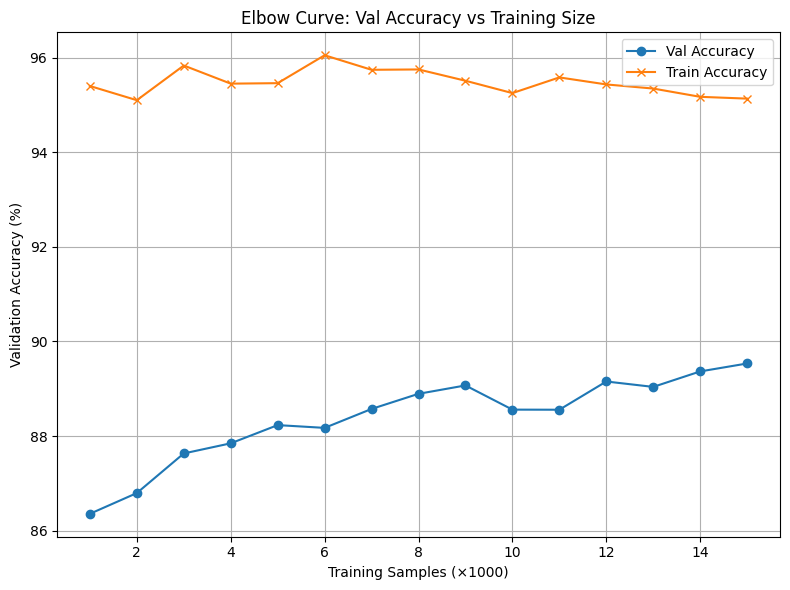

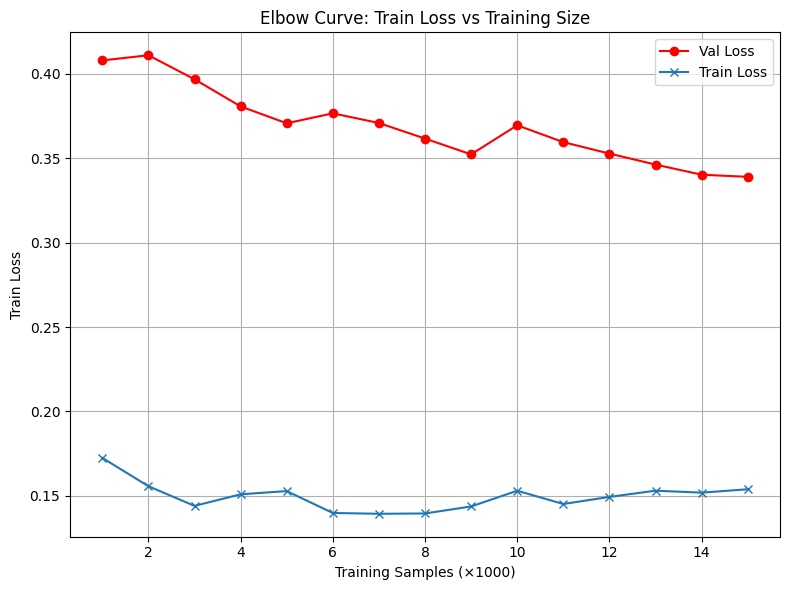

In [30]:
if flag_subsampled:
    def plot_elbow_curve(elbow_history):
        x_vals = [x / 1000 for x in elbow_history["subset_size"]]
    
        # Accuracy
        plt.figure(figsize=(8, 6))
        y_vals = [acc * 100 for acc in elbow_history["val_accuracy"]]
        plt.plot(x_vals, y_vals, marker='o', label='Val Accuracy')
        plt.plot(x_vals, [acc * 100 for acc in elbow_history['train_accuracy']], marker='x', label='Train Accuracy')
        plt.xlabel("Training Samples (×1000)")
        plt.ylabel("Validation Accuracy (%)")
        plt.title("Elbow Curve: Val Accuracy vs Training Size")
        plt.grid(True)
        plt.legend()
        plt.tight_layout()
        plt.show()
    
        # Train Loss
        plt.figure(figsize=(8, 6))
        y_vals = elbow_history["val_loss"]  # raw loss
        plt.plot(x_vals, y_vals, marker='o', color='red', label='Val Loss')
        plt.plot(x_vals, elbow_history["train_loss"], marker='x', label='Train Loss')
        plt.xlabel("Training Samples (×1000)")
        plt.ylabel("Train Loss")
        plt.title("Elbow Curve: Train Loss vs Training Size")
        plt.grid(True)
        plt.legend()
        plt.tight_layout()
        plt.show()
        
    plot_elbow_curve(elbow_history)

else: 
    epochs = range(1, EPOCHS + 1)

    plt.figure(figsize=(12, 5))
    
    # Plot Loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label='Train Loss')
    plt.plot(epochs, val_losses, label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Train vs Val Loss')
    plt.legend()
    plt.grid(True)
    
    # Plot Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accs, label='Train Accuracy')
    plt.plot(epochs, val_accs, label='Val Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Train vs Val Accuracy')
    plt.legend()
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()

## Saving Results

In [31]:
if flag_subsampled:
    def save_elbow_results_to_excel(filename, elbow_history):
        # Load or create workbook
        if os.path.exists(filename):
            wb = load_workbook(filename)
            ws = wb.active
        else:
            wb = Workbook()
            ws = wb.active
    
            # Header row with bold font
            headers = ["Experiments", "Results"]
            bold_font = Font(bold=True)
            ws.append(headers)
    
            for col_num in range(1, len(headers) + 1):
                ws.cell(row=1, column=col_num).font = bold_font
    
        # For each subset size, append a row
        for i in range(len(elbow_history["subset_size"])):
            subset = elbow_history["subset_size"][i]
            train_acc = elbow_history["train_accuracy"][i] * 100
            train_loss = elbow_history["train_loss"][i]
            val_acc = elbow_history["val_accuracy"][i] * 100
            val_loss = elbow_history["val_loss"][i]
            val_avg_f1 = elbow_history["val_avg_f1"][i] * 100
            kappa = elbow_history["kappa"][i]
    
    
            experiment_name = f"Labeled Samples: {subset}"
            results_str = (
                f"TrainAcc = {train_acc:.2f}%, "
                f"TrainLoss = {train_loss:.4f},\n"
                f"ValAcc = {val_acc:.2f}%, "
                f"ValLoss = {val_loss:.4f},\n"
                f"AvgF1 = {val_avg_f1:.2f}%, "
                f"Kappa = {kappa:.4f}"
            )
    
            ws.append([experiment_name, results_str])
    
        wb.save(filename)
        print(f"Results saved to {filename}")
    
save_elbow_results_to_excel(
    filename="Results.xlsx",
    elbow_history=elbow_history
)

Results saved to Results.xlsx


<hr>